In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'soccertrack:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2481051%2F4977082%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240913%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240913T051535Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Dc2b13a8eb17d9e7fe2588d4619edf121ce24e205dc209620ec4ec7a46d24f409964122329ca3bae511537c969a76466b6a203ccf0145c0d88bb66e3f409599d98e260cf9cc6626647c526f73e26c0c6807ceeed12c7f5e3398ed7006ed9b753b847f250206810f7e568530d963de96a6b8a1080d7747a7d1b530959e699713fa5828794b864e2b46150c375a78122429b4128eb8a457601f566524b529e60fcf177c304d79c1c419de67821ec6d9330204e10f2245e6ad3aedf9b0e80610ff9552521b8ec14928ee4ac4c787dbcf220421702469d721d4269b4e30eaa4b00f07c536bf6e86699705be580b06ab7a610acab152a7998c30b0144e4a4133d05243'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 6773384913 bytes downloaded
Downloaded and uncompressed: soccertrack
Data source import complete.


# Цель проекта:

  1. Реализовать алгоритм, который определяет, какое давление p оказывается на каждого игрока в игре по информации о координатах этих же игроков x, y.
  2. Обучить модель, для прогнозирования положения игрока x(t + τ ), y(t + τ ) на временной горизонт τ и, как следствие, давления, оказываемого на него p(t + τ ).
    

# Содержание
    1. Введение
    2. Подготовка данных
    3. Алгоритм определения давления на игрока
    4. Модель прогнозирования давления на игрока

## Введение

  `Давление на игрока` - один из ключевых параметров, влияющих на игру. В данной работе мы постараемся создать алгоритм для определения давления на игрока, а так же построить модель, которая будет определять давление на игрока через определенный промежуток времени.

## Подготовка данных

В качестве данных мы используем публичный датасет на платформе [Kaggle](https://www.kaggle.com/datasets/atomscott/soccertrack). За основу мы взяли работу, где уже описана [выгрузка данных](https://www.kaggle.com/code/chaozhuang/soccertrack-collective-dynamics-analysis).

In [2]:
# импортируем библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import seaborn as sns
import os
import glob
import math

# Animate the changing characteristic area in a fast-forward video
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from functools import partial

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore', category=FutureWarning, module='seaborn')

Загружаем данные

In [3]:
# Loading data
# Plot style
colors = sns.color_palette()

# Kaggle
path = '/kaggle/input/soccertrack/top_view/annotations/'

# Local
# path = 'top_view/annotations/'

# Loading data
csv_files = glob.glob(os.path.join(path, "*.csv"))
csv_files.sort()
data = pd.read_csv(csv_files[0], header=None)

# Dropping the original first few rows, and the first column
data = data.drop([0, 1, 2, 3])

# Concatenating all the annotation files
for file in csv_files[1:]:
    # Preprocessing temp files
    temp = pd.read_csv(file, header=None)
    temp = temp.drop([0, 1, 2, 3])
    temp = temp.iloc[:,1:]

    # Concatenating with the previous file
    data = pd.concat([data, temp])

# Reset the indices and remove the wrong one
data = data.reset_index()
data = data.iloc[:,2:]

# Converting data type into floats
data = data.astype(float)

Преобразуем данные в координаты x и y для каждого игрока и для мяча.

In [4]:
# Converting bounding box coordinates into xy coordinates
num_columns = len(data.columns)
group_size = 4
num_players = num_columns // group_size

for i in range(num_players):
    group_columns = data.iloc[:, i*group_size:(i+1)*group_size]
    result_column_name = f'player_{i}_x'
    data[result_column_name] = group_columns.iloc[:,1] + group_columns.iloc[:,3] / 2
    result_column_name = f'player_{i}_y'
    data[result_column_name] = group_columns.iloc[:,2] + group_columns.iloc[:,0] / 2

# Correcting the final coordinates as the ball coordinates
data = data.rename({'player_22_x':'ball_x', 'player_22_y':'ball_y'}, axis = 1)

# Remove the redundant bbox coordinates
data = data.iloc[:,-46:]

data.head()

player_0_x  player_0_y  player_1_x   player_1_y  player_2_x  player_2_y  \
0      820.50     1070.50      1483.5  1099.500000     1939.50      1079.5   
1      821.25     1071.75      1483.5  1099.192308     1936.75      1080.5   
2      822.00     1073.00      1483.5  1098.884615     1934.00      1081.5   
3      822.75     1074.25      1483.5  1098.576923     1931.25      1082.5   
4      823.50     1075.50      1483.5  1098.269231     1928.50      1083.5   

   player_3_x  player_3_y  player_4_x  player_4_y  ...  player_18_x  \
0      1907.5      532.50      1586.5      1404.5  ...       2331.5   
1      1909.5      532.25      1588.0      1404.5  ...       2331.5   
2      1911.5      532.00      1589.5      1404.5  ...       2331.5   
3      1913.5      531.75      1591.0      1404.5  ...       2331.5   
4      1915.5      531.50      1592.5      1404.5  ...       2331.5   

   player_18_y  player_19_x  player_19_y  player_20_x  player_20_y  \
0        531.5     1931.500     1335.500       2271.5  1383.500000   
1        531.1     1931.375     1335.125       2271.5  1383.475610   
2        530.7     1931.250     1334.750       2271.5  1383.451220   
3        530.3     1931.125     1334.375       2271.5  1383.426829   
4        529.9     1931.000     1334.000       2271.5  1383.402439   

   player_21_x  player_21_y    ball_x    ball_y  
0  2556.500000  1165.500000  1921.000  1078.000  
1  2556.357143  1165.214286  1915.625  1078.625  
2  2556.214286  1164.928571  1910.250  1079.250  
3  2556.071429  1164.642857  1904.875  1079.875  
4  2555.928571  1164.357143  1899.500  1080.500  

[5 rows x 46 columns]

In [ ]:
data.describe()

player_0_x    player_0_y    player_1_x    player_1_y    player_2_x  \
count  54023.000000  54023.000000  54023.000000  54023.000000  54023.000000   
mean     912.144401   1051.790779   1363.232929   1225.430215   2048.443061   
std      328.789943    165.600150    402.175082    327.230360    521.646970   
min      337.000000    519.000000    482.000000    360.000000    508.500000   
25%      665.000000    927.500000    991.000000    980.000000   1828.000000   
50%      853.000000   1061.000000   1376.666667   1214.500000   2040.500000   
75%     1095.000000   1143.000000   1734.000000   1470.500000   2379.000000   
max     2627.000000   1668.500000   2197.000000   2065.000000   3242.000000   

         player_2_y    player_3_x    player_3_y    player_4_x    player_4_y  \
count  54023.000000  54023.000000  54023.000000  54023.000000  54023.000000   
mean    1003.905568   2094.555555   1057.188781   1509.694815   1516.289414   
std      392.276455    456.300553    350.276263    378.483552    295.731424   
min       76.500000    774.000000    117.500000    492.500000    575.500000   
25%      756.500000   1823.761364    800.000000   1247.000000   1269.000000   
50%     1011.500000   2049.000000   1046.500000   1551.565789   1515.000000   
75%     1248.500000   2426.500000   1329.696343   1790.500000   1772.792140   
max     2056.500000   3170.000000   2046.500000   2770.000000   2067.500000   

       ...   player_18_x   player_18_y   player_19_x   player_19_y  \
count  ...  54023.000000  54023.000000  54023.000000  54023.000000   
mean   ...   1707.180687    615.152629   1455.117121    957.066180   
std    ...    467.183944    279.439804    391.588937    326.782067   
min    ...    628.500000     74.500000    452.000000    163.500000   
25%    ...   1378.000000    411.000000   1128.500000    717.000000   
50%    ...   1692.000000    589.000000   1456.500000    960.000000   
75%    ...   2020.500000    815.000000   1771.000000   1196.500000   
max    ...   3049.000000   1641.000000   2453.000000   1993.000000   

        player_20_x   player_20_y   player_21_x   player_21_y        ball_x  \
count  54023.000000  54023.000000  53978.000000  53978.000000  52753.000000   
mean    1724.894688   1406.569993   2234.983368   1165.330565   1732.061902   
std      483.536963    342.274429    454.397979    369.048076    776.404916   
min      494.500000    538.500000    627.000000      2.000000    281.000000   
25%     1399.500000   1122.305556   1943.500000    922.535714   1015.428571   
50%     1673.500000   1439.500000   2181.000000   1161.000000   1733.666667   
75%     2050.000000   1673.408333   2547.229167   1388.416667   2366.000000   
max     3217.000000   2073.000000   3410.000000   2057.500000   3489.000000   

             ball_y  
count  52753.000000  
mean    1017.859847  
std      571.719467  
min        0.500000  
25%      548.000000  
50%      973.000000  
75%     1481.461538  
max     2158.500000  

[8 rows x 46 columns]

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54023 entries, 0 to 54022
Data columns (total 46 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   player_0_x   54023 non-null  float64
 1   player_0_y   54023 non-null  float64
 2   player_1_x   54023 non-null  float64
 3   player_1_y   54023 non-null  float64
 4   player_2_x   54023 non-null  float64
 5   player_2_y   54023 non-null  float64
 6   player_3_x   54023 non-null  float64
 7   player_3_y   54023 non-null  float64
 8   player_4_x   54023 non-null  float64
 9   player_4_y   54023 non-null  float64
 10  player_5_x   54023 non-null  float64
 11  player_5_y   54023 non-null  float64
 12  player_6_x   54023 non-null  float64
 13  player_6_y   54023 non-null  float64
 14  player_7_x   54023 non-null  float64
 15  player_7_y   54023 non-null  float64
 16  player_8_x   54023 non-null  float64
 17  player_8_y   54023 non-null  float64
 18  player_9_x   54023 non-null  float64
 19  play

In [ ]:
# Проверим, есть ли пропуски
data.isnull().sum()

player_0_x        0
player_0_y        0
player_1_x        0
player_1_y        0
player_2_x        0
player_2_y        0
player_3_x        0
player_3_y        0
player_4_x        0
player_4_y        0
player_5_x        0
player_5_y        0
player_6_x        0
player_6_y        0
player_7_x        0
player_7_y        0
player_8_x        0
player_8_y        0
player_9_x        0
player_9_y        0
player_10_x     300
player_10_y     300
player_11_x       0
player_11_y       0
player_12_x     108
player_12_y     108
player_13_x       0
player_13_y       0
player_14_x       0
player_14_y       0
player_15_x       0
player_15_y       0
player_16_x       0
player_16_y       0
player_17_x     156
player_17_y     156
player_18_x       0
player_18_y       0
player_19_x       0
player_19_y       0
player_20_x       0
player_20_y       0
player_21_x      45
player_21_y      45
ball_x         1270
ball_y         1270
dtype: int64

In [5]:
# Заполним пропуски соседними значениями.
data = data.interpolate(method='index')

In [6]:
data.isnull().sum().sum()

0

Функция для вырисовки футбольного поля

In [ ]:
# Plotting the full-game trajectory of the Player 1
def draw_soccer_field(ax):
    # Standard soccer field dimensions in meters
    field_length_m = 105
    field_width_m = 68

    # Scale factors
    field_length_px = 3840 * 0.75
    field_width_px = field_length_px / (field_length_m / field_width_m)  # Maintain aspect ratio

    # Field position
    field_left = (3840 - field_length_px) / 2
    field_top = (2160 - field_width_px) / 2

    # Drawing the field
    rect = plt.Rectangle((field_left, field_top), field_length_px, field_width_px, edgecolor='black', facecolor='none', lw=2)
    ax.add_patch(rect)

    # Scale for meters to pixels
    scale_x = field_length_px / field_length_m
    scale_y = field_width_px / field_width_m

    # Center Circle
    center_circle_radius_m = 9.15  # Standard center circle radius
    center_circle = plt.Circle((3840 / 2, 2160 / 2), center_circle_radius_m * scale_x, color='black', fill=False, lw=2)
    ax.add_patch(center_circle)

    # Goal Areas (6-yard box)
    goal_area_length_m = 5.5
    goal_area_width_m = 18.32
    goal_area_left = plt.Rectangle((field_left, 2160 / 2 - (goal_area_width_m * scale_y / 2)),
                                   goal_area_length_m * scale_x, goal_area_width_m * scale_y,
                                   edgecolor='black', facecolor='none', lw=2)
    goal_area_right = plt.Rectangle((3840 - field_left - goal_area_length_m * scale_x, 2160 / 2 - (goal_area_width_m * scale_y / 2)),
                                    goal_area_length_m * scale_x, goal_area_width_m * scale_y,
                                    edgecolor='black', facecolor='none', lw=2)
    ax.add_patch(goal_area_left)
    ax.add_patch(goal_area_right)

    # Vertical Center Line
    plt.plot([3840 / 2, 3840 / 2], [field_top, field_top + field_width_px], color='black', lw=2)
    return scale_x

Напишем код для определения траектории движения каждого игрока

In [ ]:
def player_track(player):
    if player < 11:
        team = '1'
        color = colors[0]
    else:
        team = '2'
        color = colors[1]
    df = data
    fig, ax = plt.subplots(figsize=(19.2, 10.8))
    # Draw the soccer field
    scale_x = draw_soccer_field(ax)
    # Plotting player positions
    ax.scatter(df.iloc[:,player*2],df.iloc[:,player*2+1], color = color)
    plt.xlim(0, 3840)
    plt.ylim(0, 2160)
    plt.gca().invert_yaxis()  # Invert y-axis to match image coordinates
    plt.title(f'Team {team} player {player} Trajectory', fontsize = 24)
    ax.axis('off')
    plt.show()

Выведем таректорию движения какого-нибудь игрока

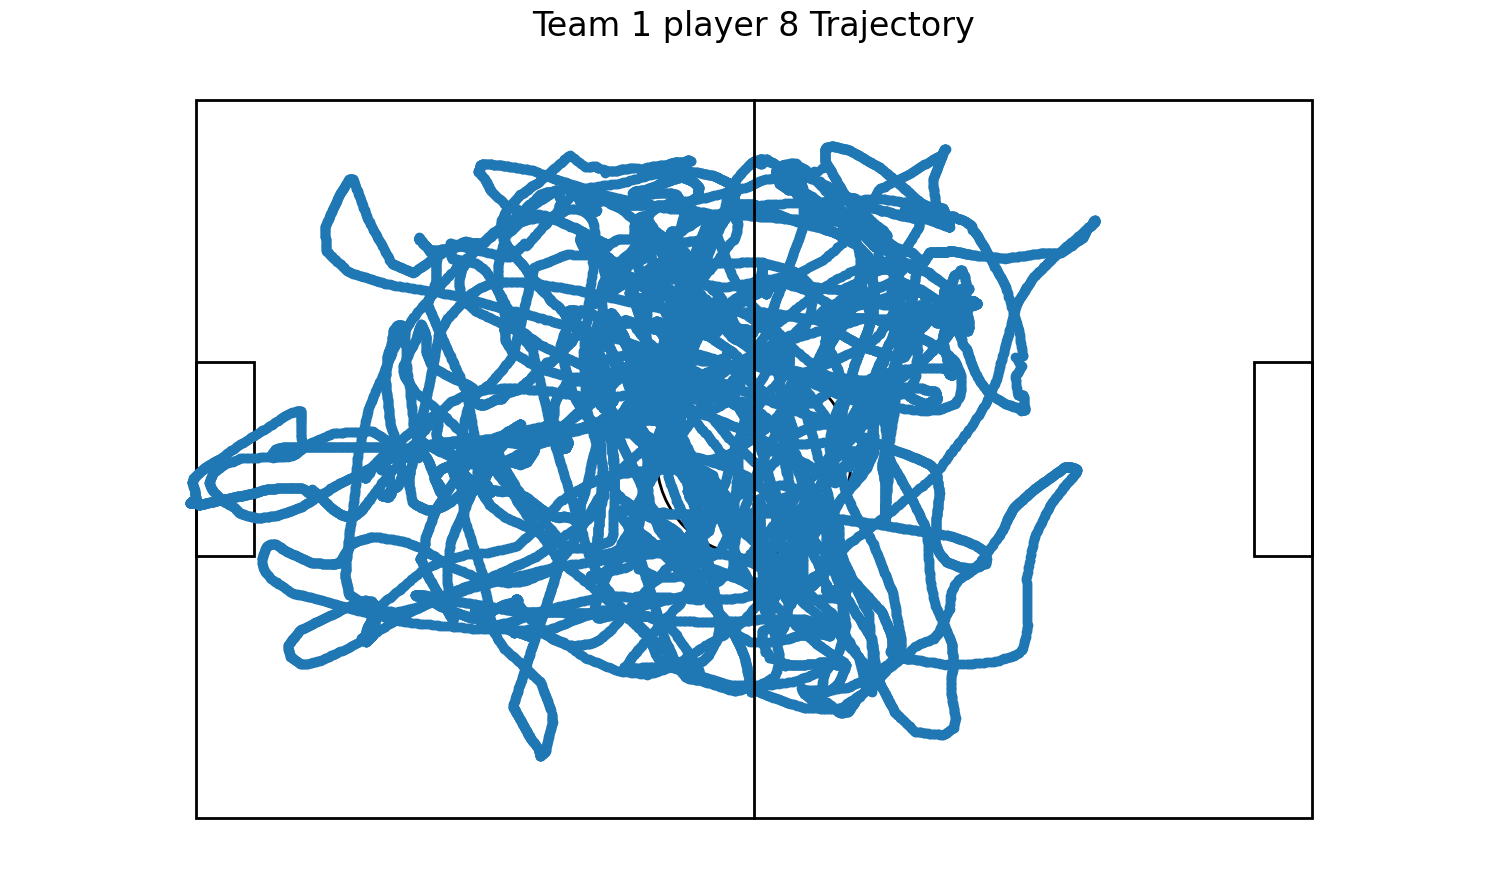

In [ ]:
player_track(8)

Так же сохраним границы футбольного поля

In [13]:
field_length_m = 105
field_width_m = 68

    # Scale factors
field_length_px = 3840 * 0.75
field_width_px = field_length_px / (field_length_m / field_width_m)  # Maintain aspect ratio

    # Field position
field_left = (3840 - field_length_px) / 2
field_top = (2160 - field_width_px) / 2
x_min = field_left
x_max = field_left+field_length_px
y_min = field_top
y_max = field_top + field_width_px
# Сохраним параметр для перевода пикселей в метры
scale_x = field_length_px / field_length_m

В качестве определения давления выберем нахождения игроков в определенном "Радиусе давления". Оставим возможность изменять этот радиус под различные тактические и аналитические задачи.

Напишем формулу, которая покажет, положение игроков в определенным кадре и "радиус давления" на нужного нам игрока

In [ ]:
def player_position(radius, frame, player):

    # Plotting all player locations at a frame
    fig, ax = plt.subplots(figsize=(19.2, 10.8))
    draw_soccer_field(ax)
    df=data
    df_frame = df.iloc[frame]
    reshaped_df = pd.DataFrame(df_frame.values.reshape(-1, 2), columns=['x', 'y'])
    # Team 1
    ax.scatter(reshaped_df.iloc[:11, 0], reshaped_df.iloc[:11, 1], color = colors[0], marker='o', s=200)

    # Team 2
    ax.scatter(reshaped_df.iloc[11:22, 0], reshaped_df.iloc[11:22, 1], color = colors[1], marker='o', s=200)

    #Pressure radius
    pie = plt.Circle((reshaped_df.iloc[player, 0], reshaped_df.iloc[player, 1]), 10*scale_x, color='black', fill=True, lw=2, alpha=0.5)
    ax.add_patch(pie)

    # Ball
    ax.scatter(reshaped_df.iloc[22, 0], reshaped_df.iloc[22, 1], color = 'black', marker='o', s=200)

    plt.xlim(0, 3840)
    plt.ylim(0, 2160)
    plt.gca().invert_yaxis()
    plt.title(f'Characteristic Area of both teams at the frame number of {frame}', fontsize = 24)
    ax.axis('off')
    plt.show()

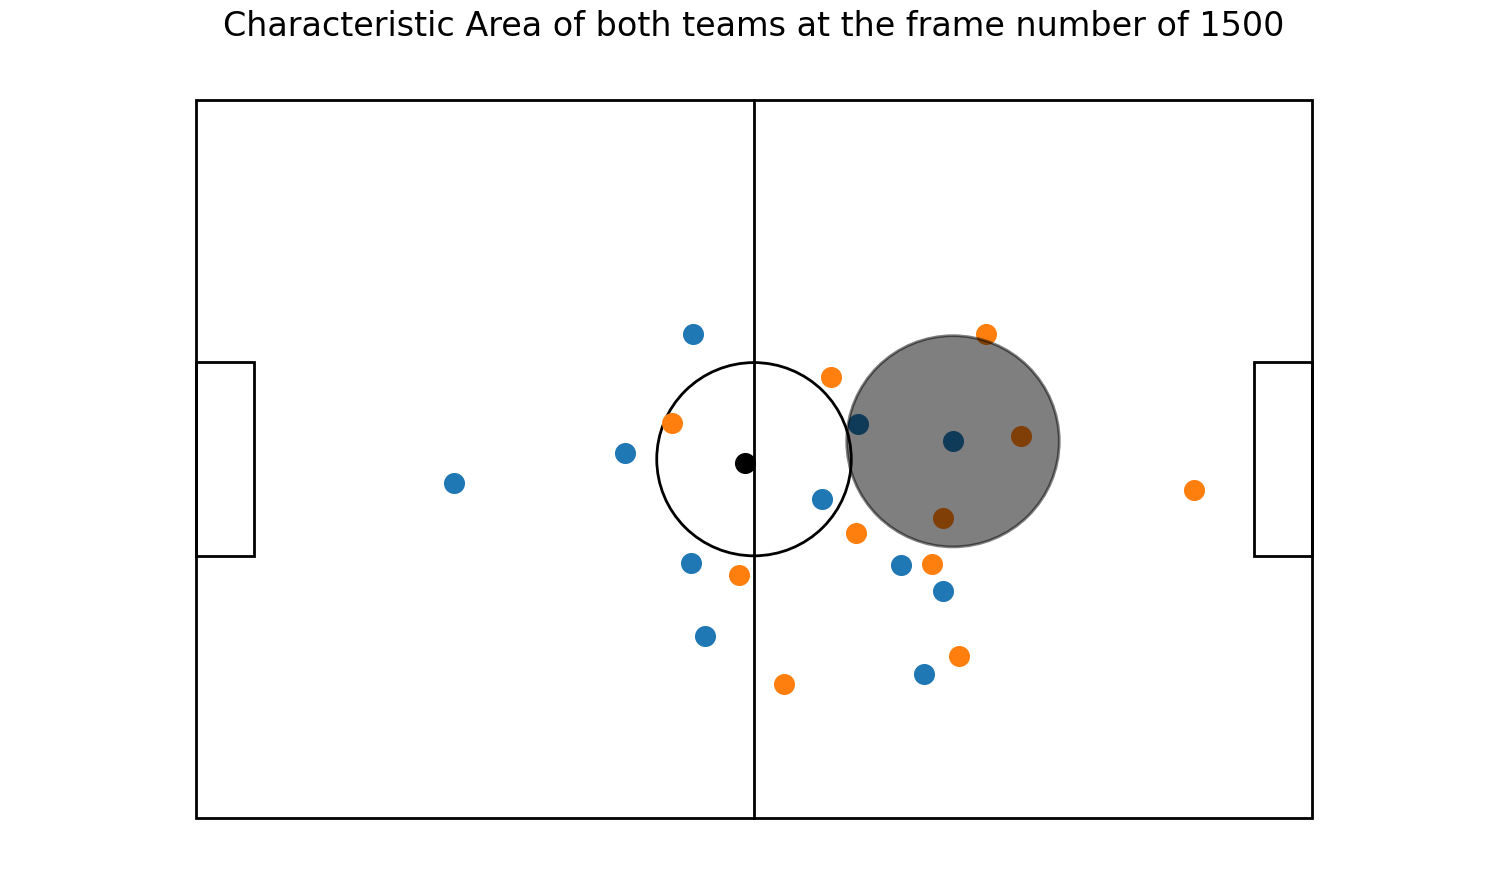

In [ ]:
player_position(10,1500,3)

Сделаем небольшую анимацию, которая наглядно покажет, как меняется количество игроков, которые попадают в "Радиус давления" к футболисту

In [ ]:
# Define the function to update each frame in the animation
def update(frame_number,player_number,radius):
    ax.clear()
    draw_soccer_field(ax)
    df_frame = df.iloc[frame_number,:46]
    reshaped_df = pd.DataFrame(df_frame.values.reshape(-1, 2), columns=['x', 'y'])

    team_1 = reshaped_df.iloc[:11]
    team_2 = reshaped_df.iloc[11:22]
    # Team 1
    ax.scatter(reshaped_df.iloc[:11, 0], reshaped_df.iloc[:11, 1], color = colors[0], marker='o', s=200)
    pie = plt.Circle((reshaped_df.iloc[player_number, 0], reshaped_df.iloc[player_number, 1]), 10*scale_x, color='black', fill=True, lw=2, alpha=0.5)
    ax.add_patch(pie)

    # Team 2
    for i in range(11):
        if math.hypot(team_2.iloc[i, 0] - team_1.iloc[player_number, 0], team_2.iloc[i, 1] - team_1.iloc[player_number, 1]) < radius*scale_x:
            ax.scatter(team_2.iloc[i,0], team_2.iloc[i,1],color = 'red', marker='o', s=200)
            ax.plot([team_2.iloc[i, 0], team_1.iloc[player_number, 0]], [team_2.iloc[i, 1], team_1.iloc[player_number, 1]], color='black')
        else:
            ax.scatter(team_2.iloc[i,0], team_2.iloc[i,1],color = colors[1], marker='o', s=200)
    #ax.scatter(reshaped_df.iloc[11:22, 0], reshaped_df.iloc[11:22, 1], color = colors[1], marker='o', s=200)

    # Ball
    ax.scatter(reshaped_df.iloc[22, 0], reshaped_df.iloc[22, 1], color = 'black', marker='o', s=200)
    plt.gca().invert_yaxis()
    plt.title('Frame: {}'.format(frame_number), fontsize = 24)



Выведем анимацию для футболиста №8

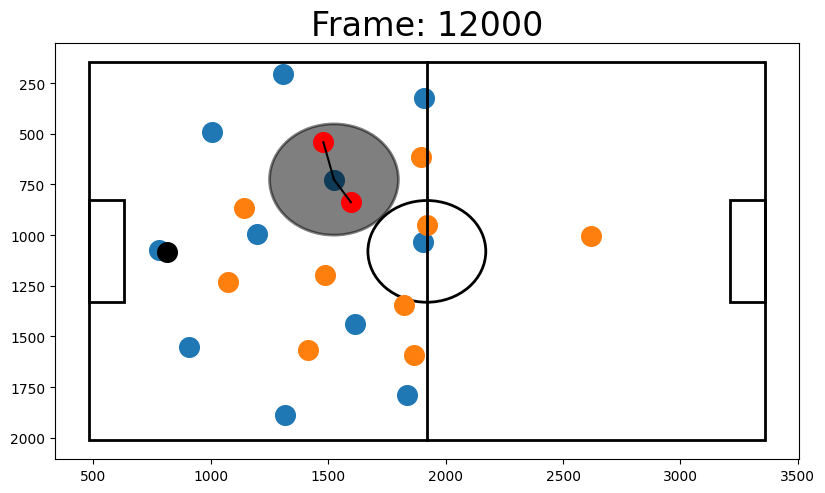

In [ ]:
# Set up the figure
fig, ax = plt.subplots(figsize=(9.6, 5.4))
draw_soccer_field(ax)
plt.xlim(0, 3840)
plt.ylim(0, 2160)
ax.axis('off')

# Frame rate
fps = 30

# Start frame
start_frame = 12000

# Calculate the number of frames for a 20-second video at the given fps
num_frames_for_video = 20 * fps
df=data
# Select a subset of rows starting from frame 3000 for the video
subset_df = df.iloc[start_frame:start_frame + num_frames_for_video]

# Create animation
ani = FuncAnimation(fig, partial(update, player_number=8,radius=10), frames=range(start_frame, start_frame + len(subset_df)), interval=1000/fps)

# Display the animation in the notebook
HTML(ani.to_html5_video())

## Численное измерение давления

Измерять величину давления на футболиста со стороны одного игрока мы будем по следующей формуле:
    
    *p_1 = 1-r/R,
    где R - "радиус давления"
        r - расстояние от оппонента до футболиста.*
        
Этот показатель нам покажет насколько близко оппонент к футболисту относительного выбранного радиуса, значение может быть от 0 до 1. Когда в радиус давлеия попадает несколько футболистов, то суммарное давление на футболиста будет равно сумме давления всех игроков, которые попадают в радиус давления.



Напишем формулу, которое определяет давление на игрока в определенные момент времени (фрейм).

In [11]:
def pressure(data,frame_number,player_number,radius):
    df_frame = data.iloc[frame_number]
    reshaped_df = pd.DataFrame(df_frame.values.reshape(-1, 2), columns=['x', 'y'])
    team_1 = reshaped_df.iloc[:11]
    team_2 = reshaped_df.iloc[11:22].reset_index(drop= True)
    p=0
    n=0
    for i in range(11):
        if math.hypot(team_2.iloc[i, 0] - team_1.iloc[player_number, 0], team_2.iloc[i, 1] - team_1.iloc[player_number, 1]) < radius*scale_x:
            r=math.hypot(team_2.iloc[i, 0] - team_1.iloc[player_number, 0], team_2.iloc[i, 1] - team_1.iloc[player_number, 1])
            p+= 1 - (r/scale_x) / radius
            n+=1
    return n,p


Проверим, какое давление оказывалось на игрока №8 во фрейме №2000

In [ ]:
n,p = pressure(data,2000,8,10)
print(f'Количество игроков в радиусе давления {n}')
print(f'Давление на игрока: {p}')

Количество игроков в радиусе давления 3
Давление на игрока: 0.6932237011994191


Это означает, что при радиусе давления в 10 метров на футболиста под №8 воздействуют 3 игрока соперника с давлением 6,93 единицы.

Давайте построим тепловые карты, чтобы посмотреть в каком месте на игрока оказывается наибольшее давление

In [ ]:
def player_pressure(player_number, radius):
    player = data[[f'player_{player_number}_x', f'player_{player_number}_y']]
    player = player.rename(columns={f'player_{player_number}_x':'x', f'player_{player_number}_y':'y'})
    p = []
    n = []
    for frame in range(len(data)):
        num,pr = pressure(data,frame,player_number,radius)
        p.append(pr)
        n.append(num)
    player.loc[:, 'p'] = p
    player['n'] = n


    return player

Построим плотность распределения давления игрока на футбольном поле

In [ ]:
def heatmap(player_number, radius):
    # Получим координаты по игроку
    player = player_pressure(player_number, radius)

    #  Делим поле на 105 (x) * 68 (y) секторов
    x_bins = np.linspace(x_min, x_max, 52)  # 105 секторов = 106 границ
    y_bins = np.linspace(y_min, y_max, 34)   # 68 секторов = 69 границ
    player['x_bin'] = pd.cut(player['x'], bins=x_bins, labels=False)
    player['y_bin'] = pd.cut(player['y'], bins=y_bins, labels=False)
    #  Создаём пустую таблицу фиксированного размера 68x105 с нулями
    empty_pv = pd.DataFrame(0, index=range(34), columns=range(52), dtype=float)
    norm = mcolors.Normalize(vmin=0, vmax=player['p'].max())
    # Агрегируем давление по секторам ()
    player_pv = player.pivot_table(index='y_bin', columns='x_bin', values='p', aggfunc='mean', fill_value=0)
    empty_pv.update(player_pv)
    fig, ax = plt.subplots(figsize=(19.2, 10.8))

    # Рисуем футбольное поле
    draw_soccer_field(ax)

    # Используем sns.heatmap для отображения тепловой карты
    extent = [x_min, x_max, y_min, y_max]
    heatmap = ax.imshow(empty_pv, cmap='Greens', interpolation='nearest', extent=extent, origin='lower', alpha=1, norm=norm)

    # Настраиваем оси (футбольное поле 0 до 3840 по x и 0 до 2160 по y)
    plt.xlim(0, 3840)
    plt.ylim(0, 2160)
    # Добавляем цветовую шкалу для давления
    plt.colorbar(heatmap, label='Давление')
    # Инвертируем ось Y, чтобы сетка накладывалась на поле корректно
    plt.gca().invert_yaxis()

    # Убираем оси, если это нужно
    ax.axis('off')

    # Показываем график
    plt.show()

Посмотрим на плотность распределения игрока под №8

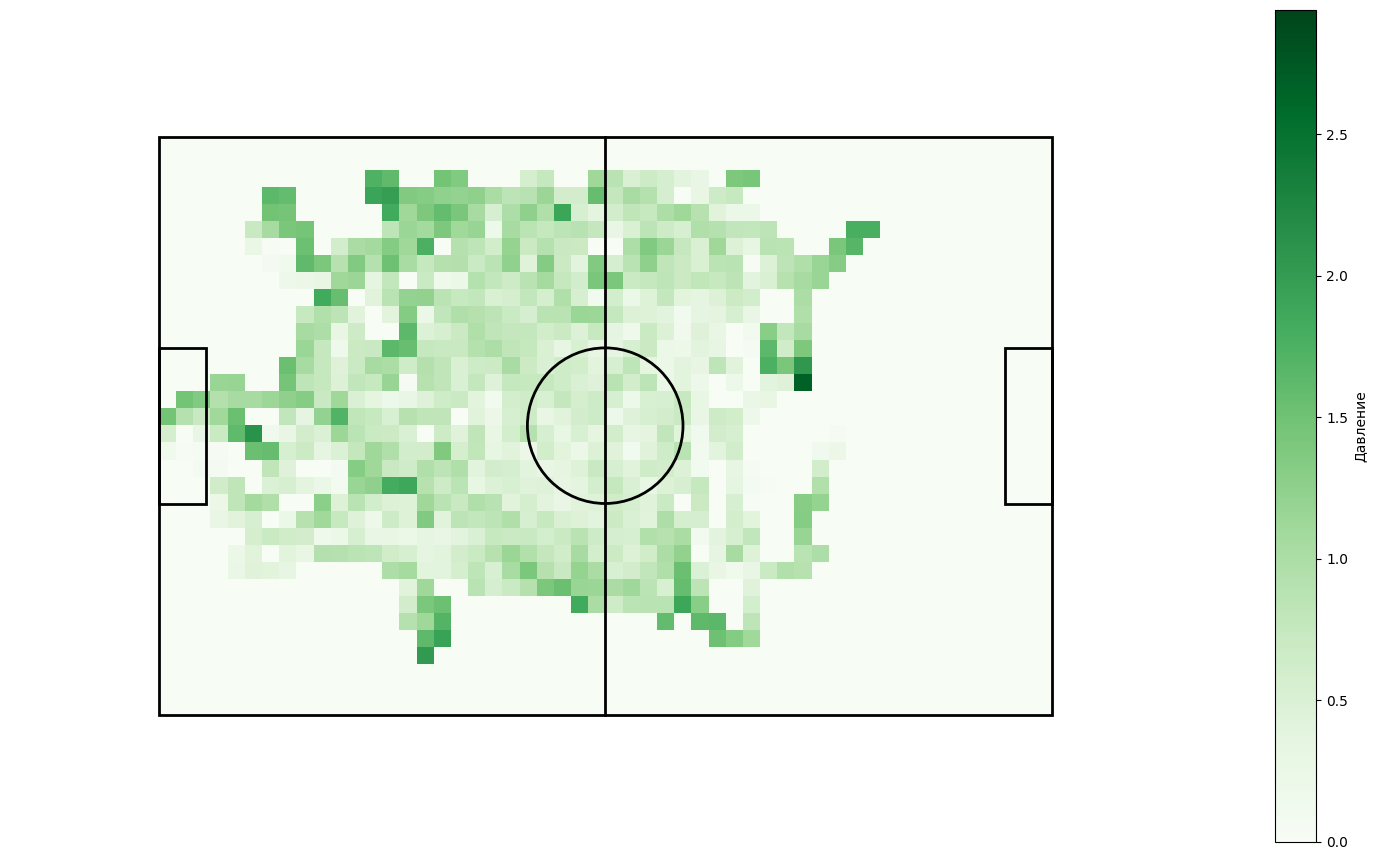

In [ ]:
heatmap(8, 10)

И на его траекторию движения

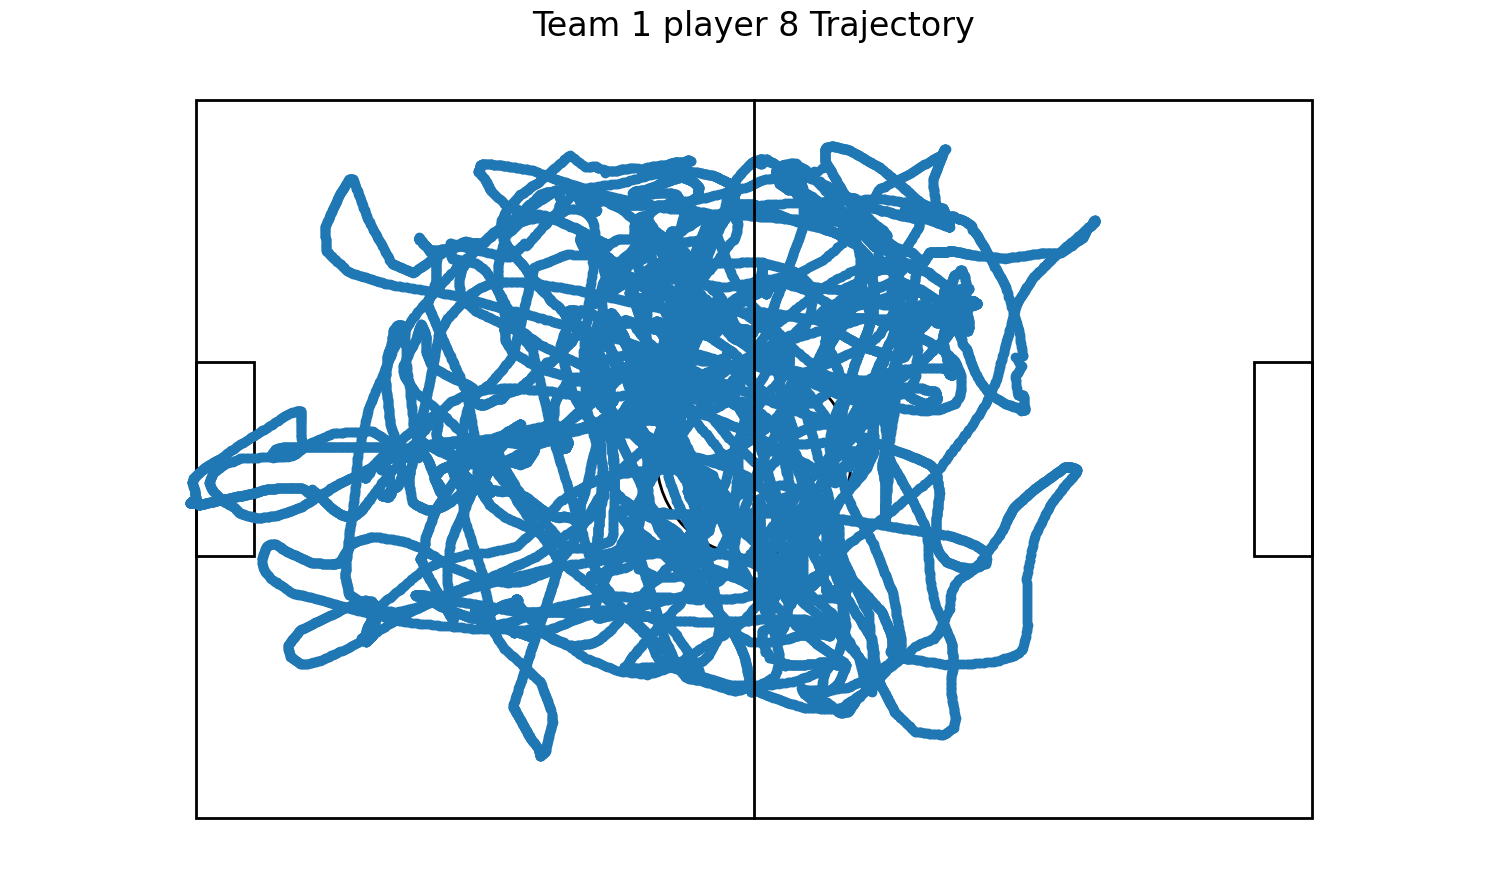

In [ ]:
player_track(8)

*Вывод* Мы видим, что на игрока под №8 наибольшее давление оказывалось при входе в финальную треть и на флангах на своей половине. В центре поля давление на игрока в целом стабильно и находится возле 1 единице при "радиусе давление" = 10.


Построим гистограммы распределения давления и количества игроков в "радиусе давления" на игроков 1 команды

In [ ]:
def hists(player_number, radius):
    player = player_pressure(player_number, radius)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
    #fig, ax = plt.subplots(figsize=(10, 6))
    n_max = int(np.ceil(player['n'].max()))
    sns.histplot(player['n'], bins=n_max, color='skyblue', edgecolor='black', ax = ax1)  # Вы можете настроить количество корзин (bins) по вашему усмотрению

    # Настройка графика
    ax1.set_title(f'Распределение количества игроков \n в "радиусе давления" {radius}м')
    ax1.set_xlabel('Значение')
    ax1.set_ylabel('Частота')

    p_max = np.ceil(player['p'].max())

    # Построение гистограммы

    sns.histplot(player['p'], bins=int(p_max*10), color='skyblue', edgecolor='black',ax = ax2,kde = True)  # Используем округленное значение как количество корзин

    # Настройка графика
    ax2.set_title('Распределение давления')
    ax2.set_xlabel('Значение')
    ax2.set_ylabel('Частота')
    plt.tight_layout()
    plt.suptitle(f'Анализ давления на игрока {player_number}', fontsize=16)
    plt.subplots_adjust(top=0.85)
    # Отображение графика
    plt.show()

Построим гистограммы распределения для всех игроков 1 команды

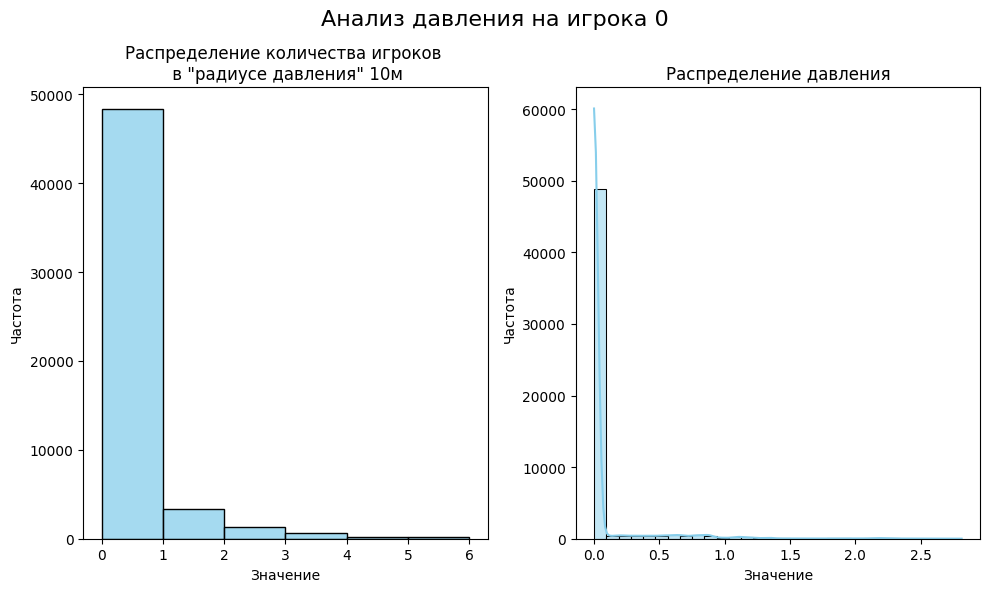

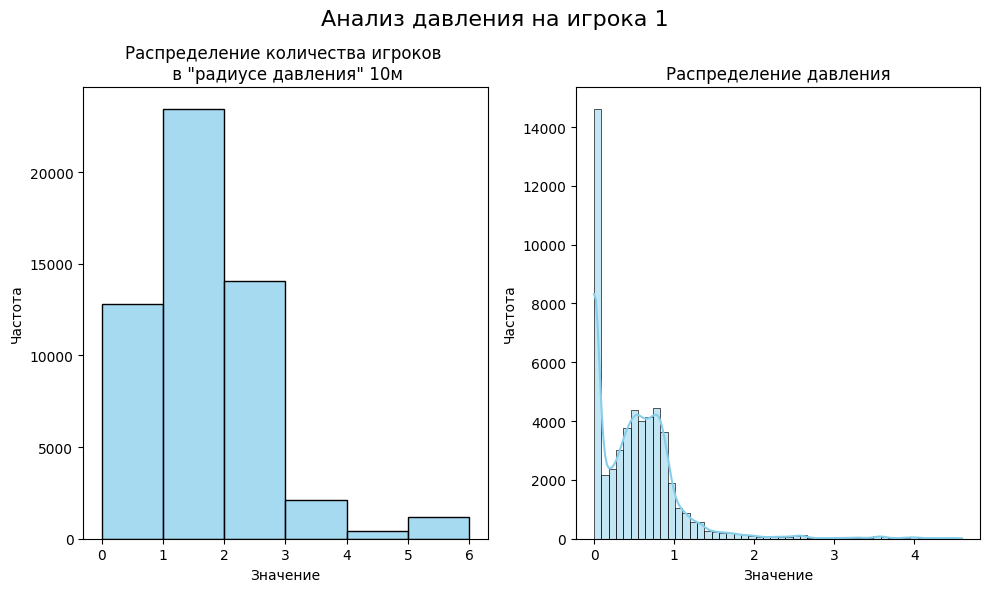

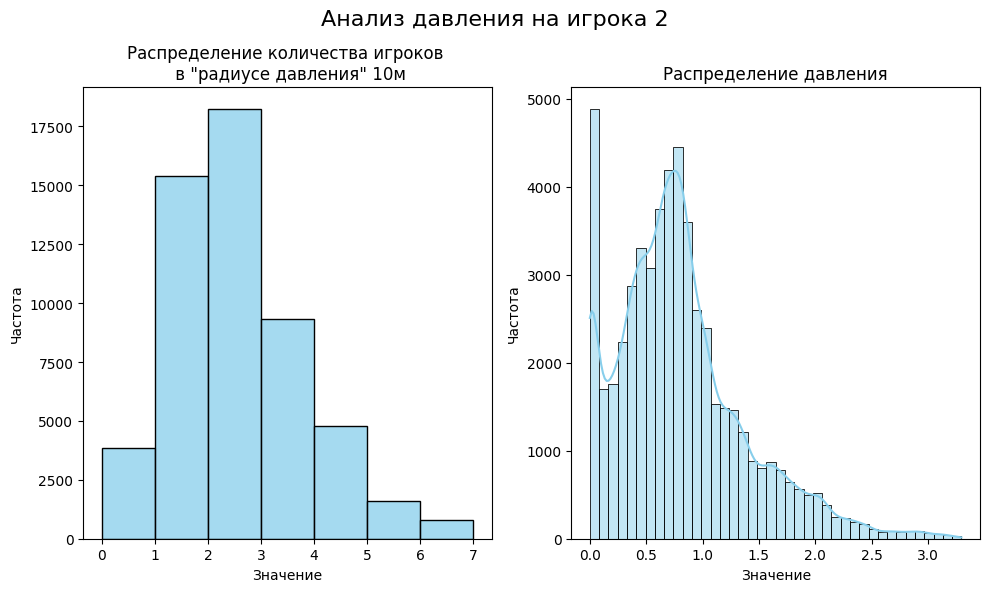

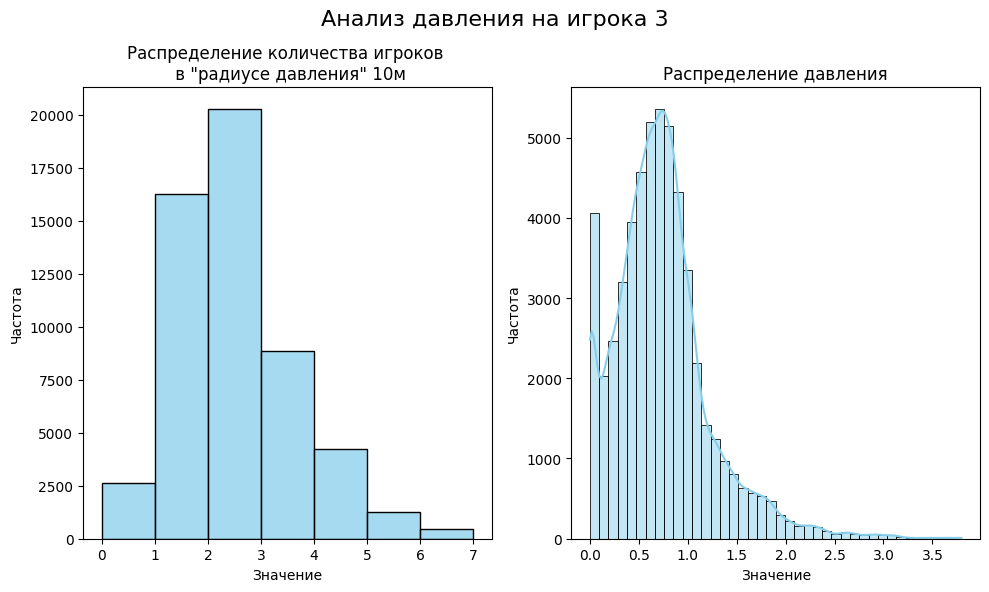

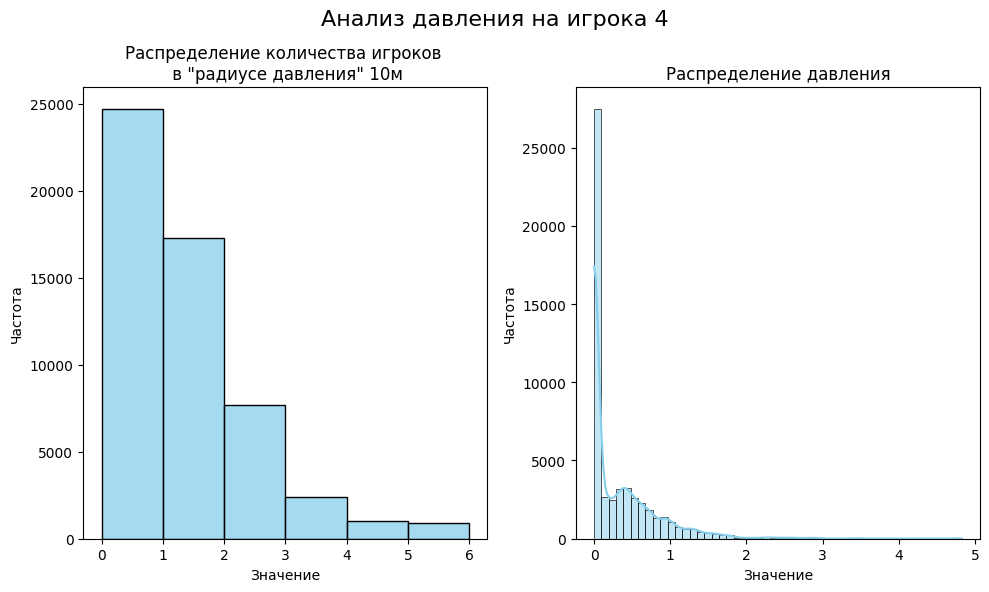

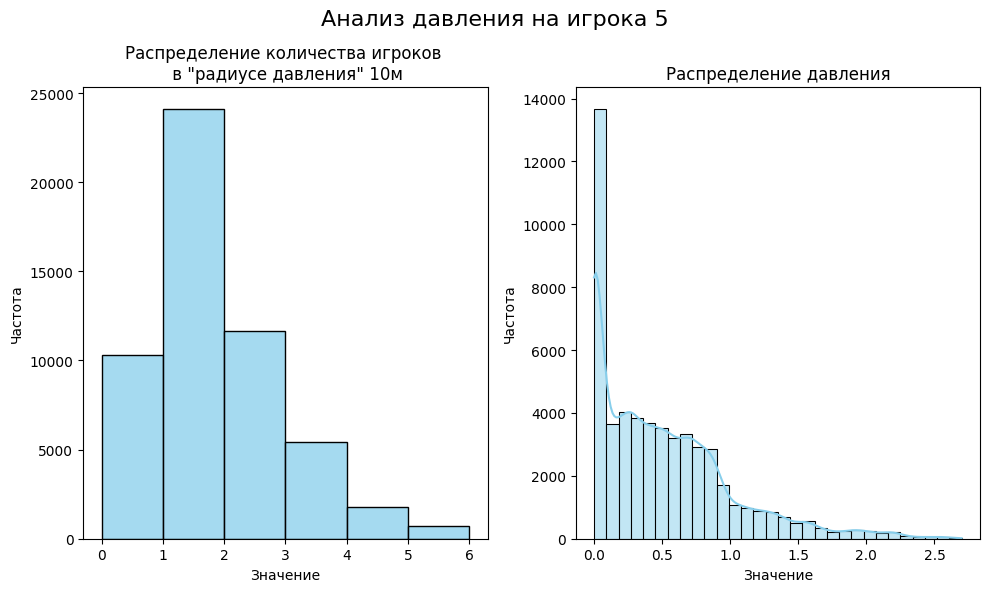

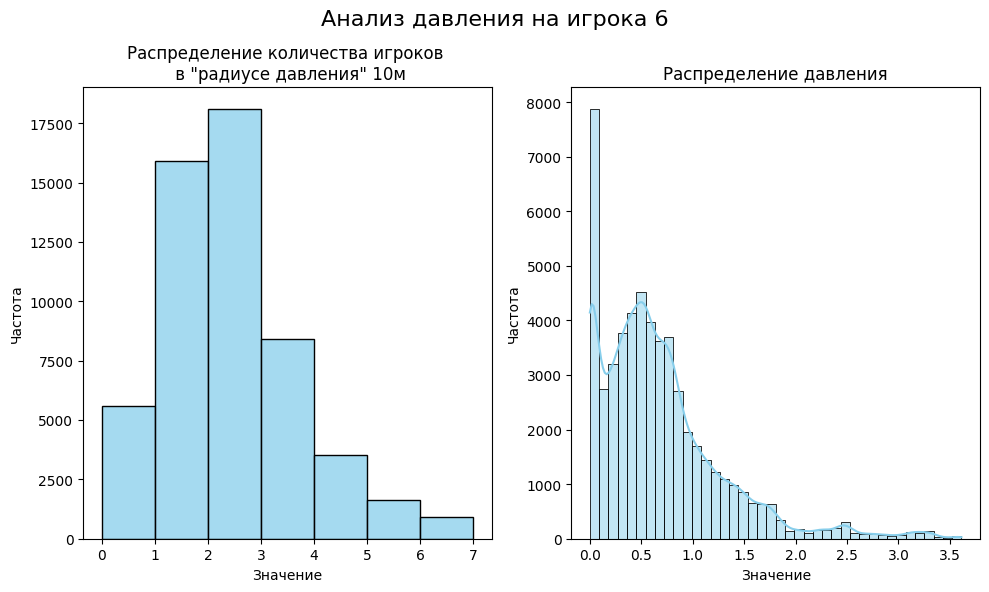

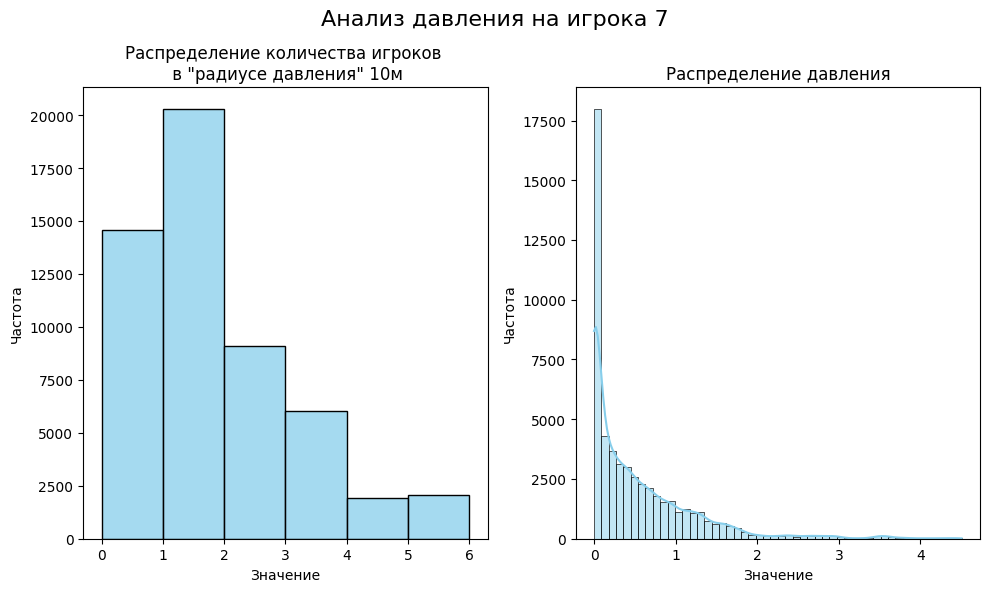

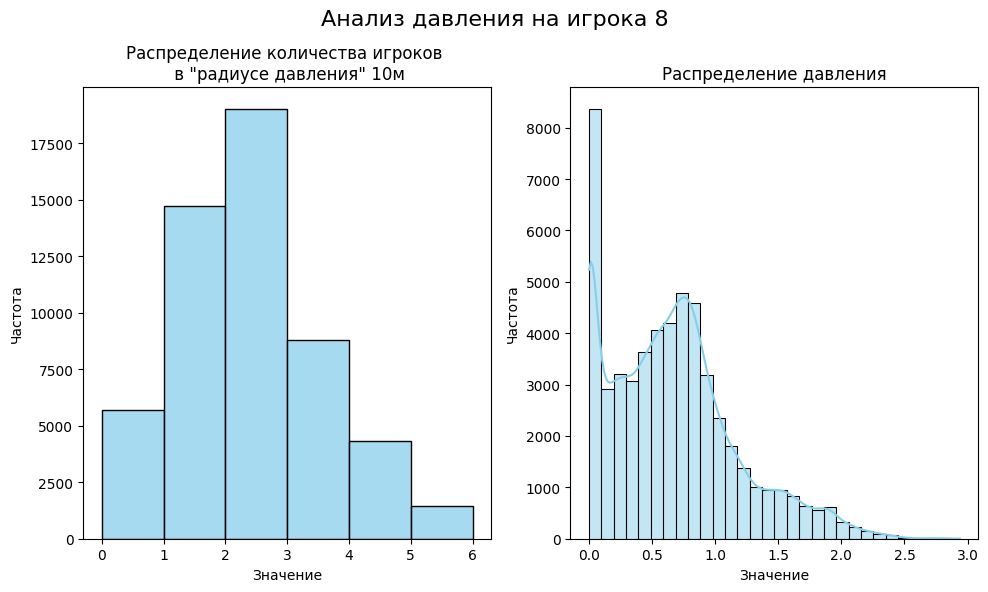

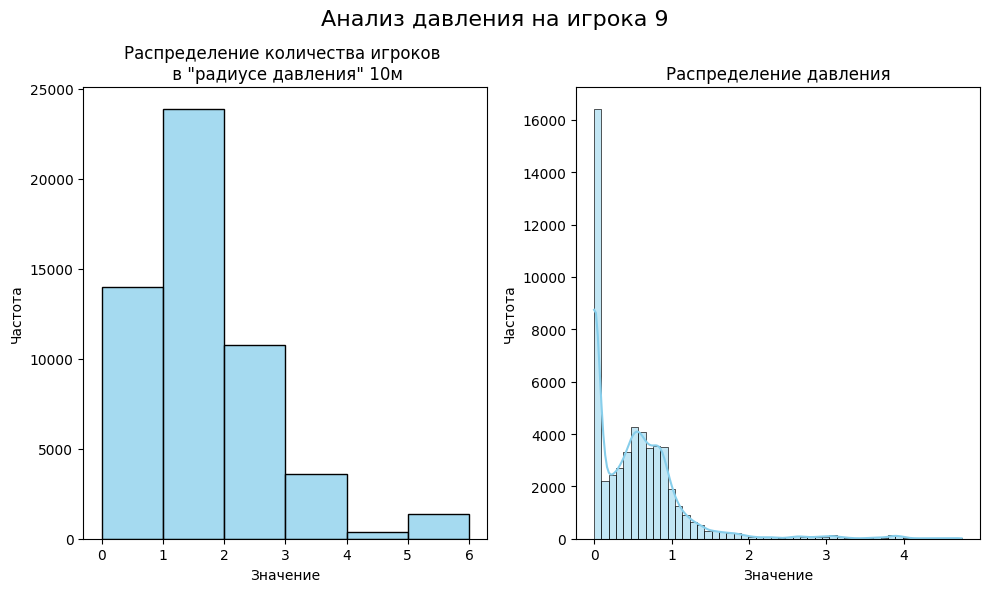

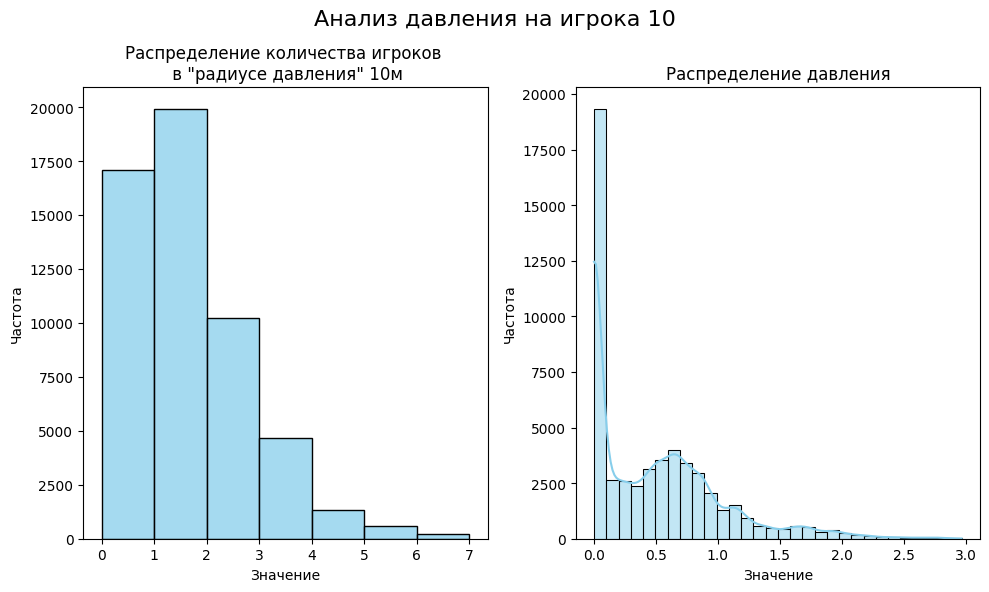

In [ ]:
for i in range (11):
    hists(i, 10)

*Вывод* Что мы видим. Во первых вратаря выделяется сразу, он болшу часть времени проводит без давления, что логично. В радиусе давления игроков 2 и 3 постоянно присутствуют игроки соперника, а в радиусе игрока №4 наоборот, много фрагментов, когда он находится без давления. Давайте посмотрим на траекторию движения игрока №4

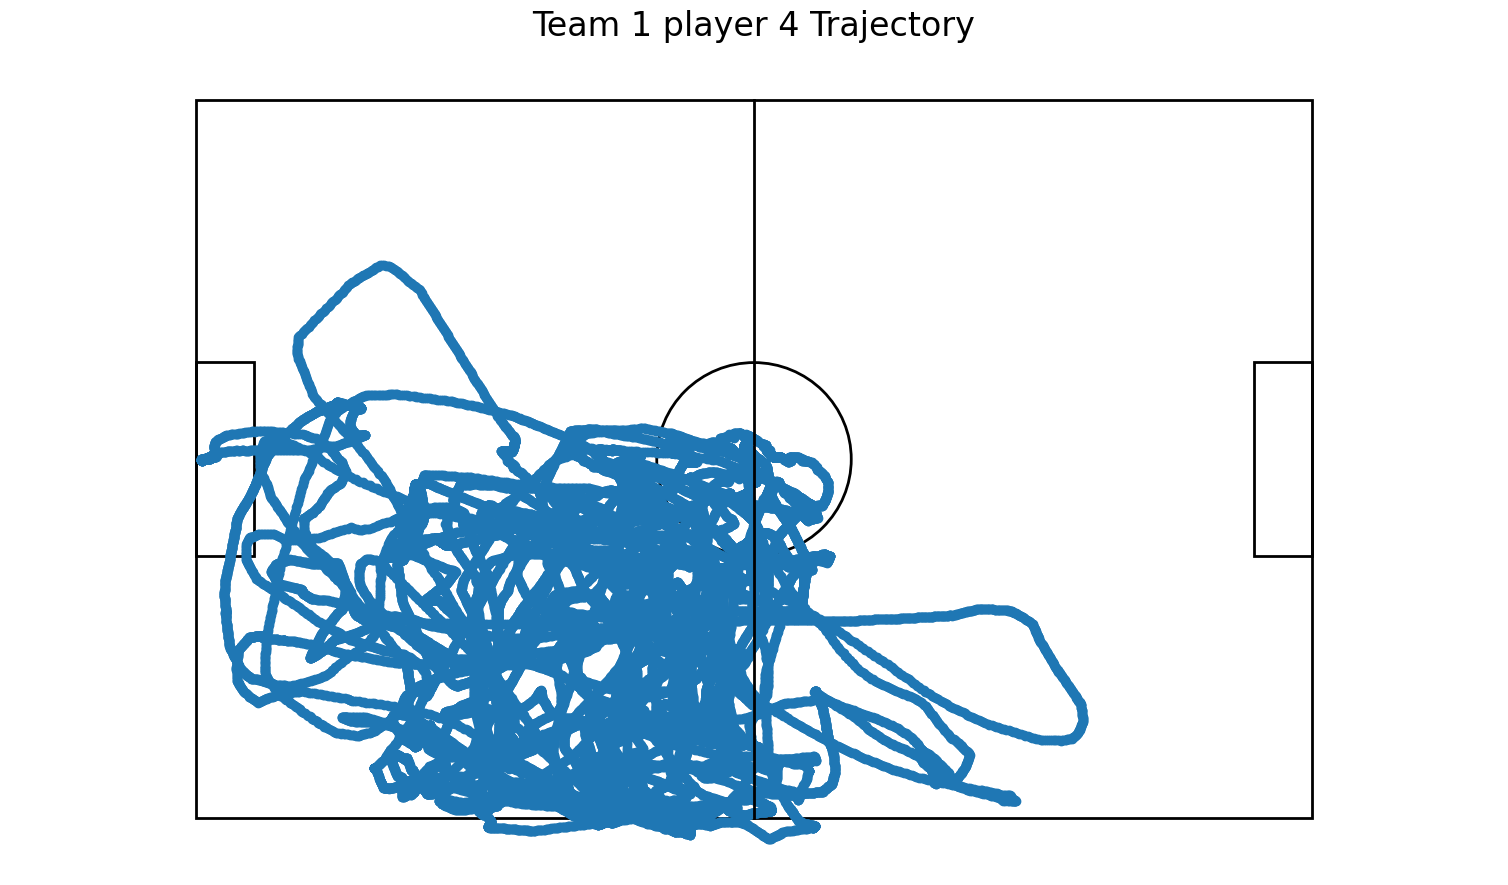

In [ ]:
player_track(4)

Судя по карте - это правый защитник. Получается, игра в большей степени проходила в центральной зоне и на левом фланге.

Давайте посмотрим на карту перемещений игрока №3, который минимальное количество времени находился без давления.

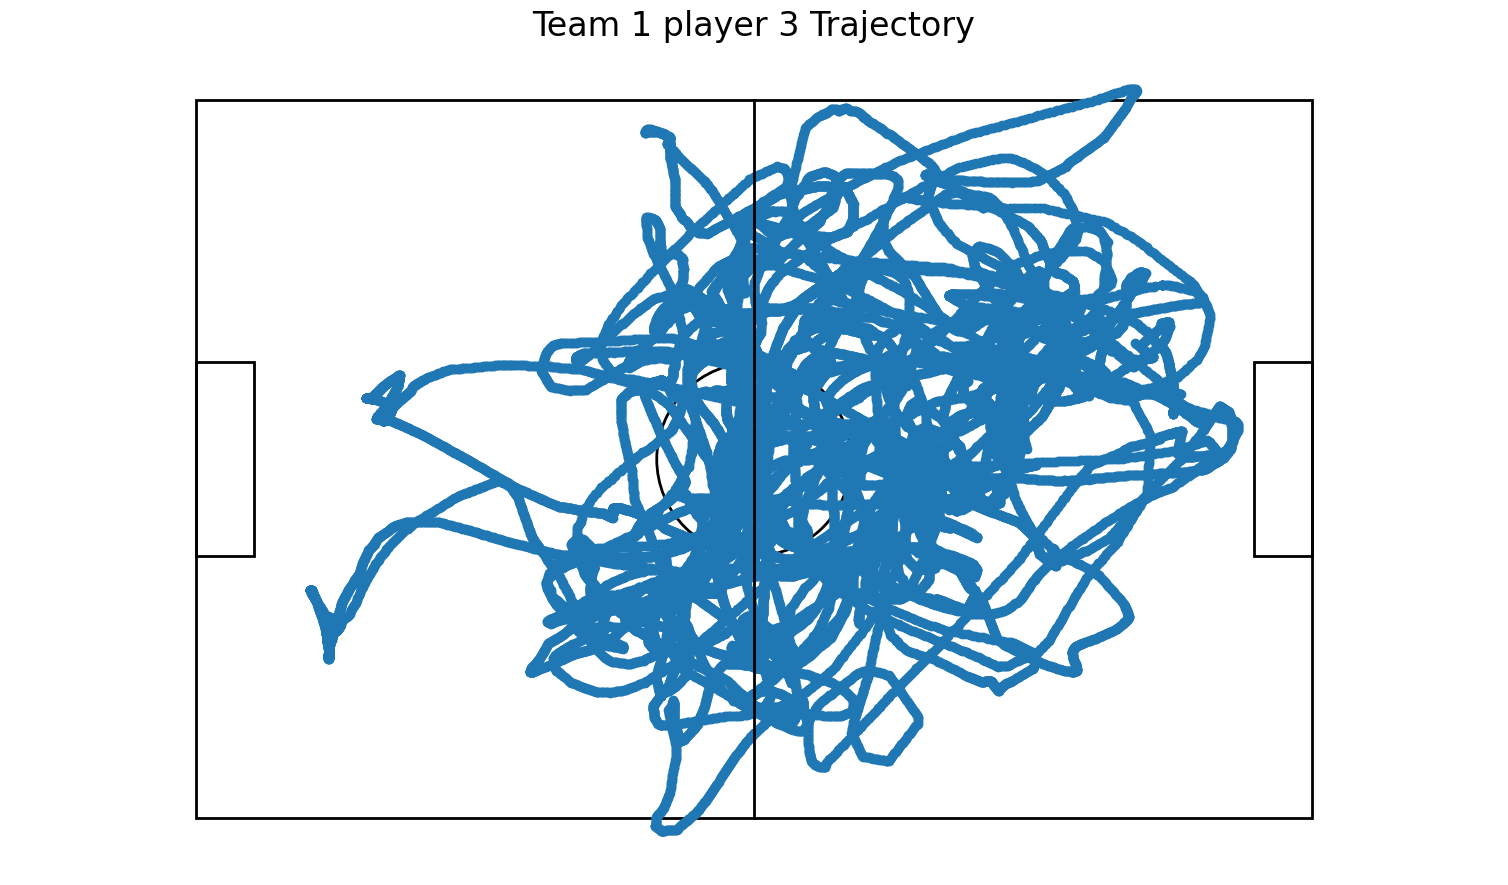

In [ ]:
player_track(3)

Карта движений указывет на то ,что игрок №3, с большей долей вероятности, нападающий.

Посмотрим на график распределения давления игрока №3 от времени

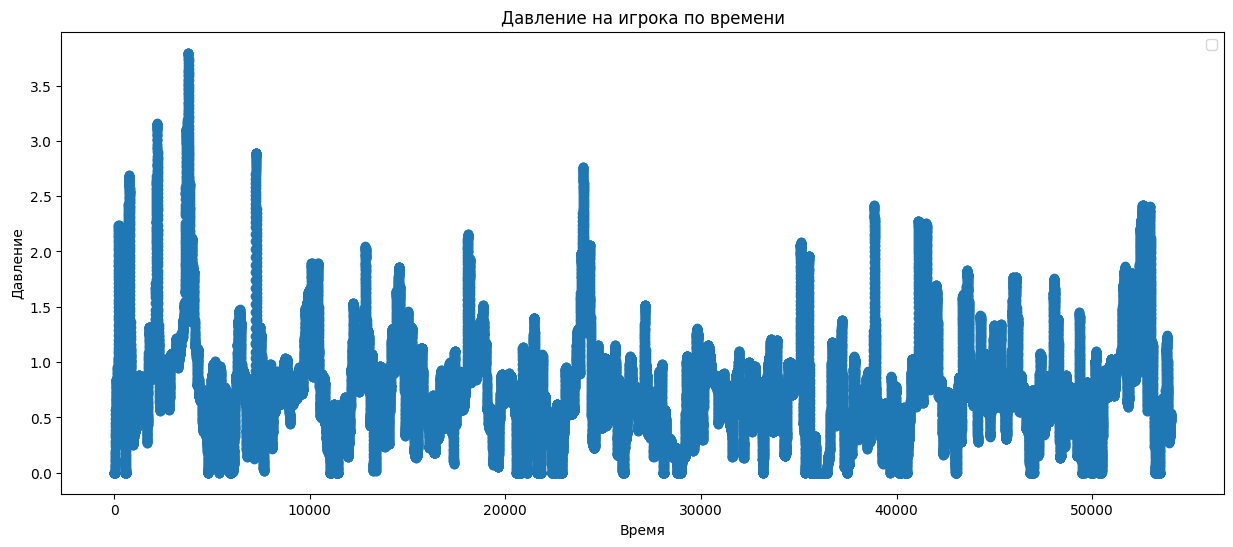

In [ ]:
# Построение графика давления по времени
player = player_pressure(3, 10)
plt.figure(figsize=(15, 6))
plt.plot(player['p'], marker='o', linestyle='-')
plt.legend()
plt.title('Давление на игрока по времени')
plt.xlabel('Время')
plt.ylabel('Давление')
plt.show()

Мы видим всплеск давления в начале видео, потом давление на игрка скачет с некоторой периодичностью. Возможно пик давления на нападающего связан либо с атакой команды, когда игрок попадает под более плотную опеку. Либо эти пики могут быть связаны со стандартными положениями. Давайте посмотрим на расположение игроков при максимальном давлении на игрока №3.

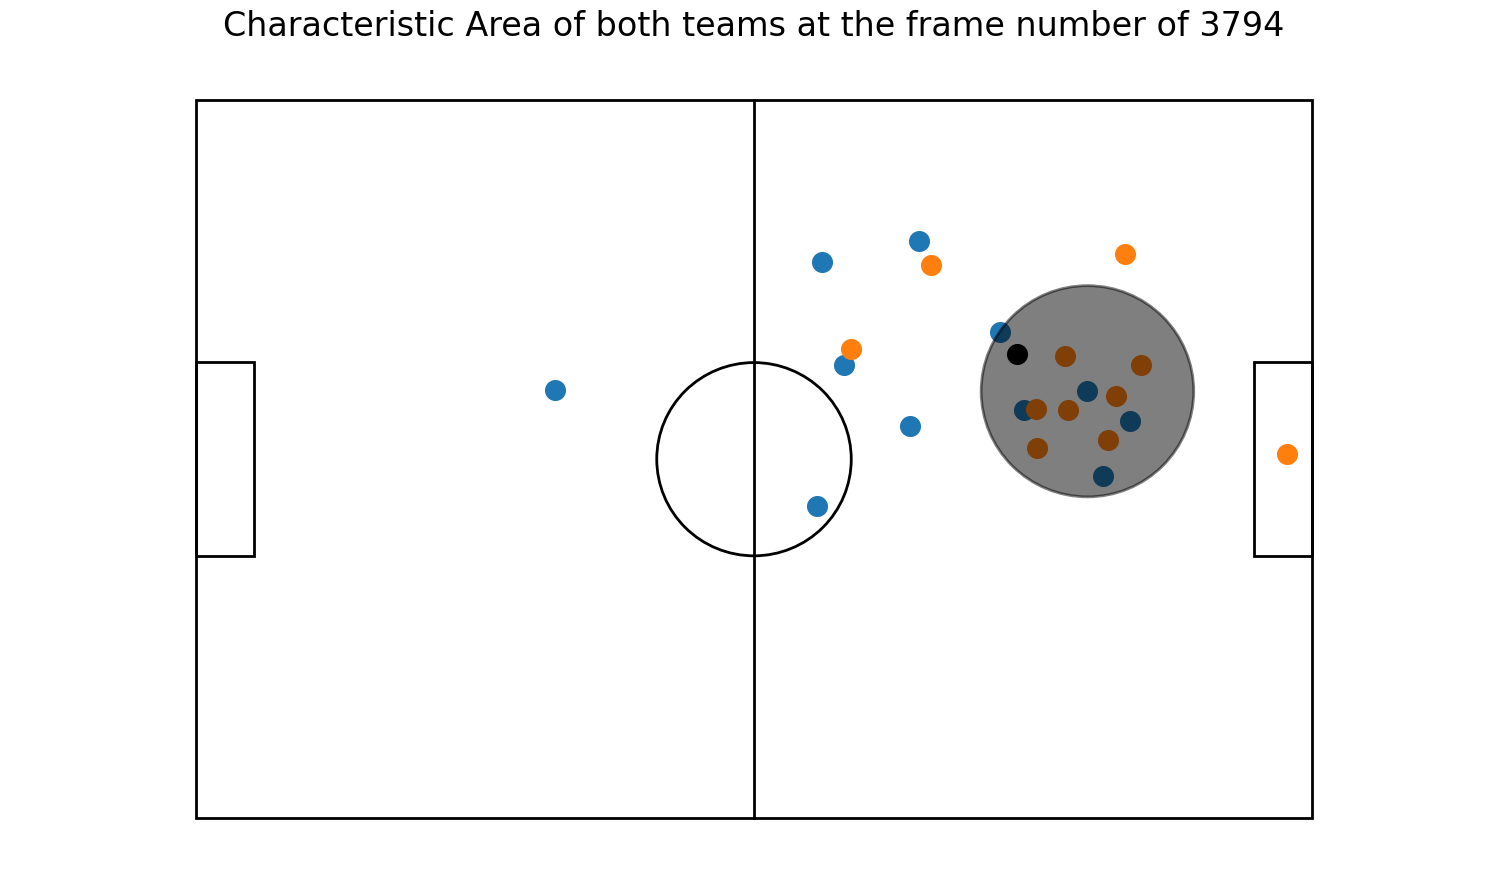

In [ ]:

player_position(10,player['p']. idxmax (),3)

Максимальное давление на игрока создалось в моменте атаки команды №1 через центральную зону, которая была перегружена игроками команды №2. В этой фазе явно не хватает включения правого защитника в огромную свободную зону. Мы выяснили, что это №4, давайте посмотрим, где он находился в этот момент.

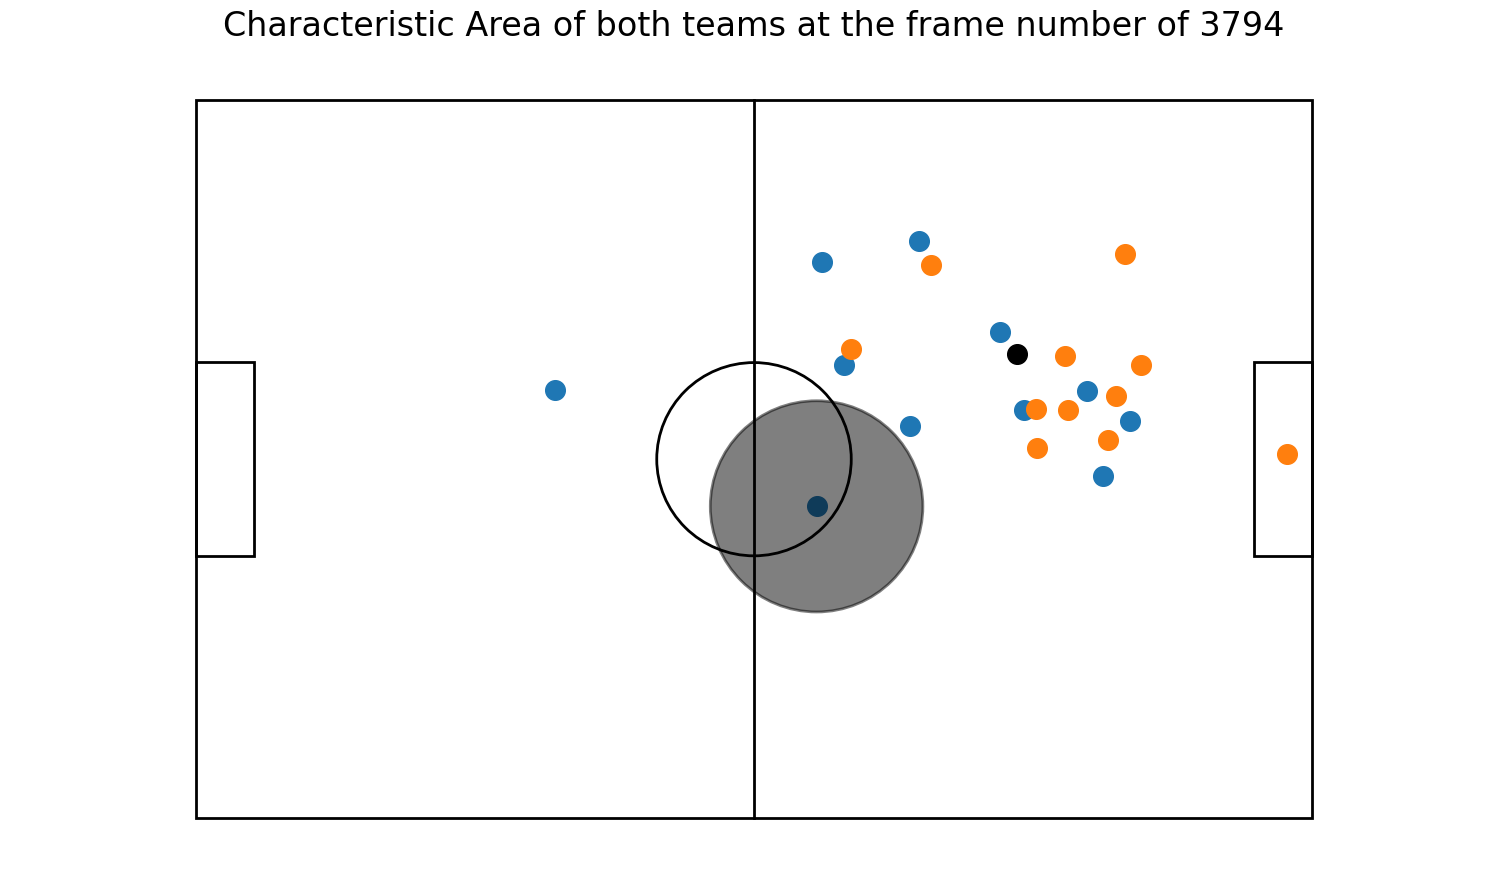

In [ ]:
player_position(10,player['p']. idxmax (),4)

Он находился в центральном круге один, не имея игроков в "радиусе давления". Это может говорить о весьма осторожной тактике команды №1.
Наконец давайте проследим атаку и посмотрим как менялось даввление на нашего нападающего.

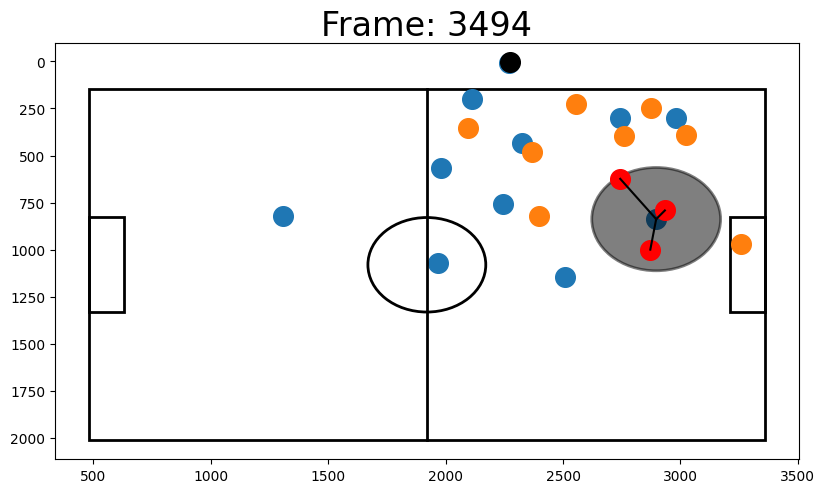

In [ ]:
# Set up the figure
fig, ax = plt.subplots(figsize=(9.6, 5.4))
draw_soccer_field(ax)
plt.xlim(0, 3840)
plt.ylim(0, 2160)
ax.axis('off')

# Frame rate
fps = 30

# Start frame
start_frame = player['p']. idxmax () - 10*30

# Calculate the number of frames for a 20-second video at the given fps
num_frames_for_video = 20 * fps
df=data
# Select a subset of rows starting from frame 3000 for the video
subset_df = df.iloc[start_frame:start_frame + num_frames_for_video]

# Create animation
ani2 = FuncAnimation(fig, partial(update, player_number=3,radius=10), frames=range(start_frame, start_frame + len(subset_df)), interval=1000/fps)

# Display the animation in the notebook
HTML(ani2.to_html5_video())

Команда имела заход в финальную треть поля после аута, но нападающе в борьбе с несколькими защитниками не смог зацепиться за мяч.

*В первом блоке мы создали алгоритм, который описывает давление на игрока в период времени.
Причем "радиус давления" может меняться в заисимости от целей анализа. В работе мы использовали **радиус давления 10 м** ,что весьма не маленькое расстояние и может указывать не только на непосредственное давление на игрока, но и показывает насколько в целом в свободном пространстве находится футболист. Если нас интересует непосредственное давление вблизи футболиста, мы можем уменьшить "радиус давления" и произвести вычисления.*

## Создание модели для прогнозирования давления на игрока

### Подготовка данных

Преобразуем кадры в секунды, учитывая ,что камера снимает 30 кадров в секунду

In [7]:
# Converting frame to second for a fewer data points and less clutter graph
def frame_to_second(df):
    # Set the starting point
    # Calculate the number of rows in the DataFrame
    num_rows = len(df)
    # Generate a datetime index - frequency is set to '33L' for 1/30th of a second (approximately 33 milliseconds)
    datetime_index = pd.date_range(start = '00:00:00', periods=num_rows, freq='33.33ms')

    # Set this as the index of the DataFrame
    df.index = datetime_index
    # Resample and aggregate by seconds
    df_second = df.resample('s').mean()

    return df_second

df_second = frame_to_second(data)

In [8]:
df_second

player_0_x   player_0_y   player_1_x   player_1_y  \
2024-09-13 00:00:00   822.602151  1072.580645  1483.758065  1098.596774   
2024-09-13 00:00:01   842.561111  1068.100000  1504.416667  1112.183333   
2024-09-13 00:00:02   885.966667  1023.933333  1542.287500  1110.650000   
2024-09-13 00:00:03   938.300000  1031.166667  1538.362500  1104.216667   
2024-09-13 00:00:04   990.183333  1039.100000  1547.950000  1103.133333   
...                          ...          ...          ...          ...   
2024-09-13 00:29:56   978.333333  1039.850000  1574.166667  1163.600000   
2024-09-13 00:29:57  1003.950000  1060.150000  1670.366667  1184.800000   
2024-09-13 00:29:58  1014.550000  1075.716667  1725.283333  1200.566667   
2024-09-13 00:29:59  1013.983333  1083.366667  1752.666667  1203.100000   
2024-09-13 00:30:00  1014.705882  1084.294118  1760.352941  1192.588235   

                      player_2_x   player_2_y   player_3_x  player_3_y  \
2024-09-13 00:00:00  1939.451613  1080.016129  1942.338710  534.790323   
2024-09-13 00:00:01  1988.900000  1093.033333  2073.033333  552.666667   
2024-09-13 00:00:02  2095.533333  1127.866667  2270.233333  579.900000   
2024-09-13 00:00:03  2239.833333  1130.900000  2461.466667  594.833333   
2024-09-13 00:00:04  2419.866667  1102.666667  2655.300000  647.333333   
...                          ...          ...          ...         ...   
2024-09-13 00:29:56  2121.266667  1080.266667  2155.666667  809.033333   
2024-09-13 00:29:57  2170.000000  1129.000000  2197.500000  818.833333   
2024-09-13 00:29:58  2213.866667  1166.100000  2236.166667  837.066667   
2024-09-13 00:29:59  2253.233333  1180.966667  2275.233333  859.233333   
2024-09-13 00:30:00  2283.470588  1179.470588  2305.294118  881.000000   

                      player_4_x   player_4_y  ...  player_18_x  player_18_y  \
2024-09-13 00:00:00  1597.629032  1391.596774  ...  2329.032258   518.258065   
2024-09-13 00:00:01  1624.566667  1382.400000  ...  2323.533333   486.250000   
2024-09-13 00:00:02  1642.516667  1355.333333  ...  2374.700000   446.933333   
2024-09-13 00:00:03  1690.650000  1348.750000  ...  2337.266667   420.900000   
2024-09-13 00:00:04  1739.333333  1354.100000  ...  2286.966667   442.566667   
...                          ...          ...  ...          ...          ...   
2024-09-13 00:29:56  1548.066667  1491.833333  ...  1576.533333   562.733333   
2024-09-13 00:29:57  1627.933333  1501.850000  ...  1621.100000   551.566667   
2024-09-13 00:29:58  1678.916667  1511.633333  ...  1665.933333   543.200000   
2024-09-13 00:29:59  1702.950000  1513.366667  ...  1721.733333   532.633333   
2024-09-13 00:30:00  1714.058824  1503.705882  ...  1756.058824   485.500000   

                     player_19_x  player_19_y  player_20_x  player_20_y  \
2024-09-13 00:00:00  1910.951613  1313.306452  2271.500000  1383.134146   
2024-09-13 00:00:01  1805.533333  1236.200000  2271.500000  1376.994715   
2024-09-13 00:00:02  1704.366667  1130.700000  2266.833333  1336.966667   
2024-09-13 00:00:03  1720.266667  1092.166667  2287.400000  1277.716667   
2024-09-13 00:00:04  1788.533333  1116.333333  2304.966667  1278.866667   
...                          ...          ...          ...          ...   
2024-09-13 00:29:56  1576.266667  1124.566667  1668.550000  1128.283333   
2024-09-13 00:29:57  1617.333333  1143.966667  1680.133333  1244.083333   
2024-09-13 00:29:58  1655.066667  1128.866667  1676.683333  1366.366667   
2024-09-13 00:29:59  1697.233333  1116.600000  1676.216667  1483.516667   
2024-09-13 00:30:00  1731.058824  1112.588235  1676.000000  1575.147059   

                     player_21_x  player_21_y       ball_x       ball_y  
2024-09-13 00:00:00  2552.338710  1157.564516  1808.943548  1094.427419  
2024-09-13 00:00:01  2537.616667  1133.350000  1629.433333  1125.766667  
2024-09-13 00:00:02  2551.183333  1120.333333  1803.016667  1122.216667  
2024-09-13 00:00:03  2624.600000  1095.233333  2294.233333  1092.516667  


Так для прогнозирования давления на игрока в период времени мы создадим датасет, в котором будут координаты всех игроков, мяча, давление на игрока в текущий момент времени, количество игроков в `радиусе давления`, а так же все показатели, смещенные во времени на несколько секунд.

In [14]:
def add_pressure(player_number, radius):
    p=[]
    n = []
    player = df_second.copy()
    for i in range(len(df_second)):
        num, pr = pressure(df_second,i,player_number, radius)
        p.append(pr)
        n.append(num)
    player.loc[:,'p'] = p
    player.loc[:,'n'] = num
    return player

Давайте попробуем спрогнозировать давление на игрока №3

In [15]:
player_3 = add_pressure(3,10)

Создадим функцию, которая добавит столбцы с координатами и давлением на игрока в предыдущие 1,3,5 секунд.

In [16]:
def create_lag_features(df, lags, players_count=22):
    lagged_columns = {}

    # Сдвиги для игроков
    for i in range(players_count):
        for lag in lags:
            lagged_columns[f'{i}_lag_{lag}_x'] = df[f'player_{i}_x'].shift(lag)
            lagged_columns[f'{i}_lag_{lag}_y'] = df[f'player_{i}_y'].shift(lag)

    # Сдвиги для мяча и давления
    for lag in lags:
        lagged_columns[f'ball_lag_{lag}_x'] = df['ball_x'].shift(lag)
        lagged_columns[f'ball_lag_{lag}_y'] = df['ball_y'].shift(lag)
        lagged_columns[f'p_lag_{lag}'] = df['p'].shift(lag)
        lagged_columns[f'n_lag_{lag}'] = df['n'].shift(lag)

    # Используем pd.concat для объединения всех задержек за один раз
    lagged_df = pd.concat(lagged_columns, axis=1)

    # Присоединяем созданные лаги к исходному датафрейму
    df = pd.concat([df, lagged_df], axis=1)

    # Удаляем строки с NaN, которые появились из-за смещений
    df.dropna(inplace=True)

    return df

lags = [1, 3, 5]
player_3 = create_lag_features(player_3, lags)

In [17]:
player_3.head()

player_0_x   player_0_y   player_1_x   player_1_y  \
2024-09-13 00:00:05  1032.633333  1043.850000  1576.616667  1105.533333   
2024-09-13 00:00:06  1065.733333  1052.666667  1625.166667  1110.233333   
2024-09-13 00:00:07  1091.300000  1059.300000  1671.983333  1110.100000   
2024-09-13 00:00:08  1113.016667  1065.216667  1718.033333  1110.100000   
2024-09-13 00:00:09  1128.203333  1065.803333  1760.900000  1101.066667   

                      player_2_x   player_2_y   player_3_x  player_3_y  \
2024-09-13 00:00:05  2621.366667  1072.000000  2836.333333  772.066667   
2024-09-13 00:00:06  2821.533333  1042.400000  2987.500000  902.166667   
2024-09-13 00:00:07  2978.500000  1016.700000  3060.983333  972.200000   
2024-09-13 00:00:08  3036.500000  1056.966667  3028.066667  957.300000   
2024-09-13 00:00:09  2978.500000  1109.133333  2933.700000  905.133333   

                      player_4_x   player_4_y  ...   p_lag_1  n_lag_1  \
2024-09-13 00:00:05  1784.100000  1361.800000  ...  0.618821      1.0   
2024-09-13 00:00:06  1823.146667  1374.733333  ...  0.887920      1.0   
2024-09-13 00:00:07  1857.136667  1385.433333  ...  1.571267      1.0   
2024-09-13 00:00:08  1883.550000  1404.083333  ...  2.179635      1.0   
2024-09-13 00:00:09  1878.133333  1408.983333  ...  1.586601      1.0   

                     ball_lag_3_x  ball_lag_3_y   p_lag_3  n_lag_3  \
2024-09-13 00:00:05   1803.016667   1122.216667  0.660494      1.0   
2024-09-13 00:00:06   2294.233333   1092.516667  0.696173      1.0   
2024-09-13 00:00:07   2675.533333   1045.416667  0.618821      1.0   
2024-09-13 00:00:08   2927.100000    990.650000  0.887920      1.0   
2024-09-13 00:00:09   3082.066667    965.966667  1.571267      1.0   

                     ball_lag_5_x  ball_lag_5_y   p_lag_5  n_lag_5  
2024-09-13 00:00:05   1808.943548   1094.427419  0.000000      1.0  
2024-09-13 00:00:06   1629.433333   1125.766667  0.055163      1.0  
2024-09-13 00:00:07   1803.016667   1122.216667  0.660494      1.0  
2024-09-13 00:00:08   2294.233333   1092.516667  0.696173      1.0  
2024-09-13 00:00:09   2675.533333   1045.416667  0.618821      1.0  

[5 rows x 192 columns]

Получили датасет с 192 столбцами, на котором уже можно строить модель

### Обучение моделей

Для начала создадим функцию, которая будет создавать датасет с признаками и датасет с целевым признаком. Целевым признаком будет давление на игрока через t секунд.

In [18]:
def create_time_series(df, t):
    df = df.dropna()
    X, y = [], []
    for i in range(len(df) - t):
        features = df.iloc[i:i+t]
        target = df.iloc[i+t]['p']
        X.append(features.values.flatten())
        y.append(target)
    return np.array(X), np.array(y)

Напишем функцию, корторая будет принимать на вход pipelin модели, датасет с признаками, значение t и выдавать лучшие параметры модели и результат `mean_squared_error`

In [39]:
def model_train_result(pipeline, player,tau):
# Разделение данных на обучающую и тестовую выборки
    X, y = create_time_series(player, tau)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,  shuffle=False)

    # Определяем GridSearchCV с 5-кратной кросс-валидацией
    grid_search = GridSearchCV(pipeline, param_grid, cv=5)

    # Обучение модели с подбором гиперпараметров
    grid_search.fit(X_train, y_train)
    scaler = StandardScaler()
    scaler.fit(X_train)  # Нормализуем на обучающей выборке
    X_test_scaled = scaler.transform(X_test)
    # Предсказание на тестовых данных
    y_pred = grid_search.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    return grid_search, mse

### Ridge-регрессия

Будем создавать датасеты для прогнозирования давления на игрока №3 команды 1 через 1 секунду. Результаты занесем в словарь `result_ridge`.

In [23]:
lags = [1, 3, 5]
# Определяем Pipeline: сначала стандартизация, потом модель
pipeline_ridge = Pipeline([
    ('scaler', StandardScaler()),  # Шаг стандартизации
    ('ridge', Ridge())  # Шаг модели Ridge-регрессии
])

# Определение гиперпараметров для GridSearchCV
param_grid = {
    'ridge__alpha': [0.1,1, 10, 100, 1000], # Диапазон значений для параметра альфа
}

player = add_pressure(3,10)
player = create_lag_features(player, lags)
_,mse = model_train_result(pipeline_ridge, player,1)

In [24]:
mse

0.23642773526467833

In [29]:
from google.colab import output
output.enable_custom_widget_manager()

In [40]:
from catboost import CatBoostRegressor
# Создание временных рядов
X, y = create_time_series(player_3, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Определение модели CatBoost
catboost_model = CatBoostRegressor(silent=True)

# Определение пайплайна
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Нормализуем данные
    ('model', catboost_model)
])

# Определение сетки параметров для GridSearchCV
param_grid = {
    'depth': [6, 8, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300]
}

grid_search = catboost_model.grid_search(param_grid, X=X_train, y=y_train , cv=5, plot=True)




MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.3840438925
bestIteration = 99

0:	loss: 0.3840439	best: 0.3840439 (0)	total: 6.58s	remaining: 2m 51s

bestTest = 0.1736670513
bestIteration = 95

1:	loss: 0.1736671	best: 0.1736671 (1)	total: 12.7s	remaining: 2m 38s

bestTest = 0.1649206325
bestIteration = 93

2:	loss: 0.1649206	best: 0.1649206 (2)	total: 17.3s	remaining: 2m 18s

bestTest = 0.2322534564
bestIteration = 199

3:	loss: 0.2322535	best: 0.1649206 (2)	total: 27.8s	remaining: 2m 40s

bestTest = 0.1664725869
bestIteration = 175

4:	loss: 0.1664726	best: 0.1649206 (2)	total: 38.3s	remaining: 2m 48s

bestTest = 0.161762095
bestIteration = 179

5:	loss: 0.1617621	best: 0.1617621 (5)	total: 47.5s	remaining: 2m 46s

bestTest = 0.1928779806
bestIteration = 299

6:	loss: 0.1928780	best: 0.1617621 (5)	total: 1m 2s	remaining: 2m 59s

bestTest = 0.1650852414
bestIteration = 238

7:	loss: 0.1650852	best: 0.1617621 (5)	total: 1m 19s	remaining: 3m 9s

bestTest = 0.1613918767
bestIteration = 284

8:	loss: 0.1613919	best: 0.161

In [41]:
# Предсказание на тестовых данных
y_pred = catboost_model.predict(X_test)

# Оценка модели
mse = mean_squared_error(y_test, y_pred)

#print(f"Best parameters: {grid_search.best_params_}")
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.0522377438256335


Результат модели Catboost сильно выше, чему у Ridge.
Давайте посмотрим на графике реальные и предсказанные значения давления.

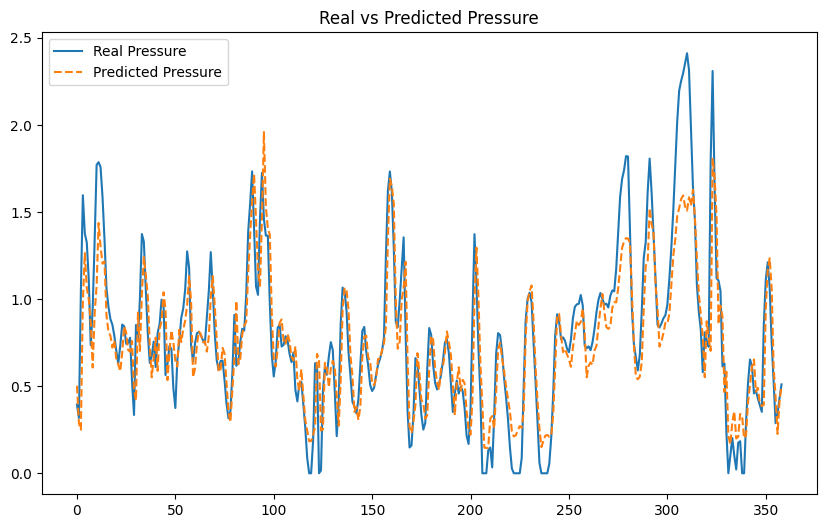

In [42]:
# Визуализация предсказанных и реальных значений давления
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Real Pressure')
plt.plot(y_pred, label='Predicted Pressure', linestyle='--')
plt.title('Real vs Predicted Pressure')
plt.legend()
plt.show()

Мы видим ,что модель CatBoost довольно неплохо предсказываеьт давление на игрока № через 1 секунду. Хоти пиковые значения давления уловить не смог. Теперь давайте провыери модель на разных значениях t

In [49]:
time = [1,3,5,10,20]
result_catboost ={}
predict={}
y_real = {}
for t in time:
  X, y = create_time_series(player_3, t)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
  catboost_model.fit(X_train,y_train)
  y_pred = catboost_model.predict(X_test)
  mse = mean_squared_error(y_test, y_pred)
  result_catboost[t] = mse
  predict[t] = y_pred
  y_real[t] = y_test

Давайте посмотрим на результаты

In [50]:
result_catboost

{1: 0.0522377438256335,
 3: 0.05406423199517902,
 5: 0.05893543323750785,
 10: 0.05279273233976489,
 20: 0.05339116695307742}

Мы видим, что с увеличением периода, ошибка практически не растет, что говорит о стабильности нашей модели. Построим таблицы реальных и предсказанных значений.

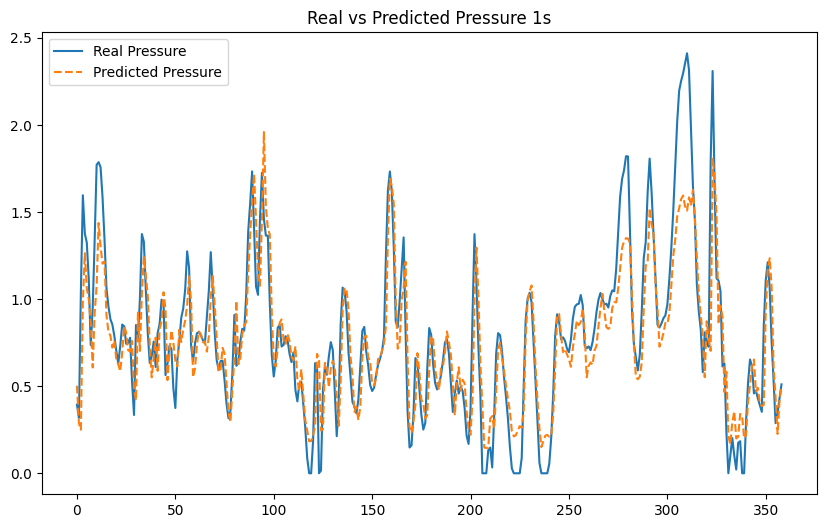

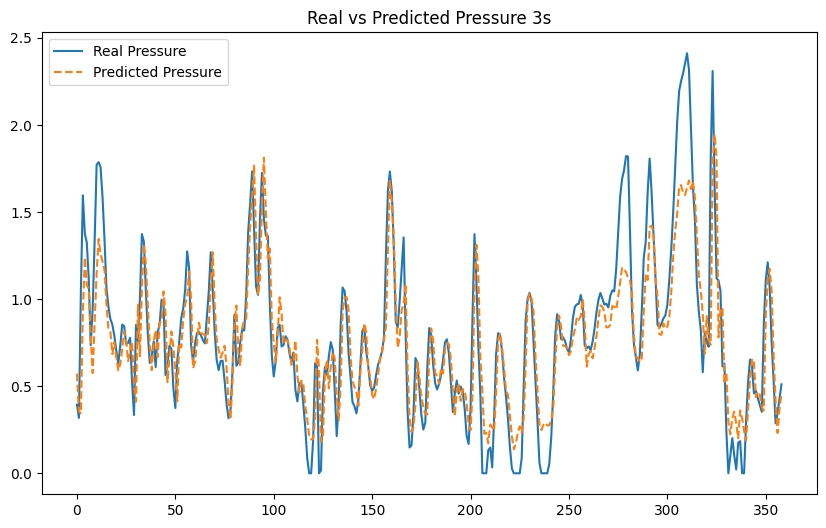

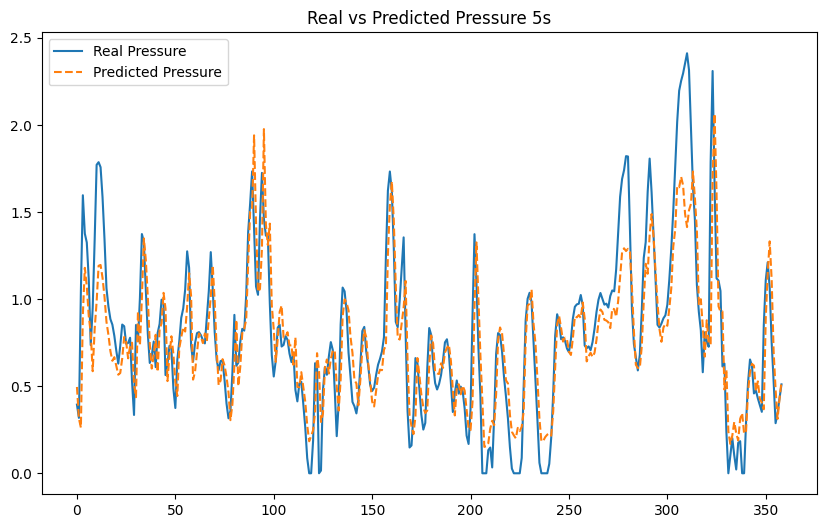

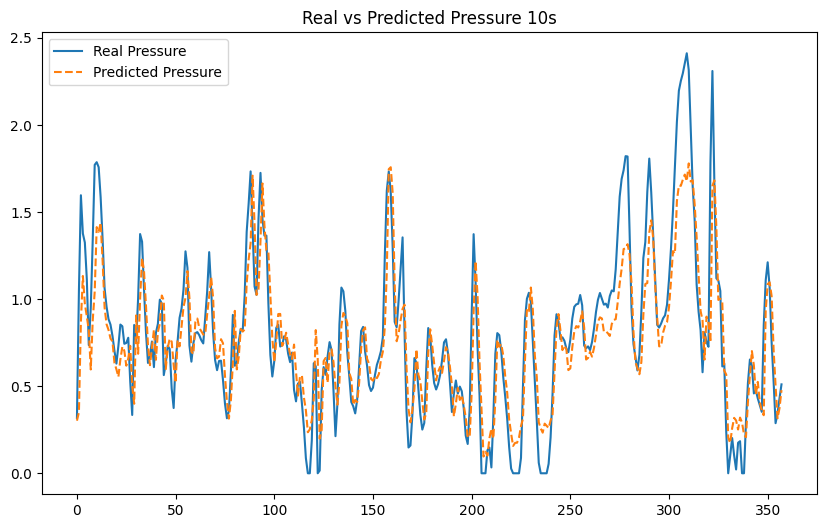

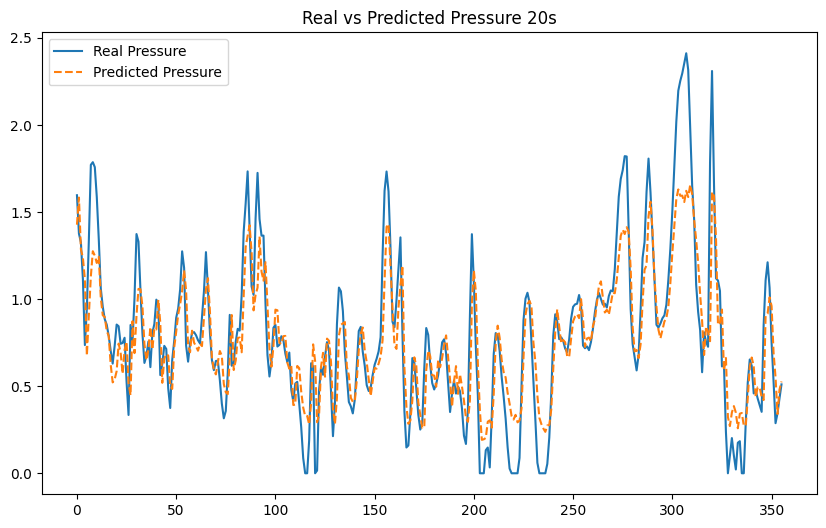

In [69]:
for t in time:
  # Визуализация предсказанных и реальных значений давления
  plt.figure(figsize=(10, 6))
  plt.plot(y_real[t], label='Real Pressure')
  plt.plot(predict[t], label='Predicted Pressure', linestyle='--')
  plt.title(f'Real vs Predicted Pressure {t}s')
  plt.legend()
  plt.show()

Мы видим, что в целом модель довольно неплохо предсказывает давление на игрока на разных промежутках времени. Но не очень хорошо отслеживает пиковые давления.

Способы улучшения модели:
  - Попробовать увеличить количество "лагов"
  - Использовать нейронные сети для предсказания временного ряда

## Вывод:
  В ходе выполнения работы мы создали алгоритм для оценки давления на игрока.
  Так же мы создали модель, которая предсказывает давление на игрока через промежуток времени.